<a href="https://colab.research.google.com/github/mirza019/Delivery-Performance-Profitability-Analysis/blob/main/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GlobalExpress - Delivery Efficiency Analysis by Mirza Shaheen Iqubal

### Background
GlobalExpress is a logistics company that delivers packages across multiple zones, supported by warehouses and drivers.  
The COO asked us to analyze their data and figure out why deliveries are often delayed and how efficiency can be improved.

This notebook walks through the entire analysis:
1. Checking the raw data  
2. Cleaning and preparing the datasets  
3. Bringing all tables together  
4. Answering the COO’s business questions  
5. Looking at financial aspects  
6. Wrapping up with clear recommendations


In [1]:
 # Importing necessary Libraries
# Core
import pandas as pd
import numpy as np
import re
from datetime import datetime
from google.colab import files

# Viz (beautiful + executive-friendly)
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# ML
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

## Setup & Styling

Here we configure display options and set up a clean **Plotly theme**.  
The goal is to make the visuals clear, consistent, and presentation-ready for non-technical stakeholders.


In [2]:


# Display defaults
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

# Plotly theme for consistent, non-technical presentation
pio.templates.default = "plotly_white"
COLOR_ACCENT = "#2E86DE"     # accent blue
COLOR_POS    = "#16A085"     # green (good)
COLOR_NEG    = "#E74C3C"     # red (bad)



## Helper Functions for Visualization

To keep the notebook clean and avoid repeating the same styling code,  
we’ll define a few helper functions:

- `kpi_card()` → to quickly show KPIs (on-time %, median delay, etc.) in a clean card style  
- `bar_ranked()` and `barh_ranked()` → to generate consistent bar and horizontal bar charts with nice formatting  

These functions will make our charts more readable for non-technical stakeholders and keep the analysis presentation-ready.


In [3]:
def kpi_card(title, value, subtitle=None, color=COLOR_ACCENT):
    fig = go.Figure()
    fig.add_annotation(
        text=f"<b style='font-size:22px'>{value}</b><br><span style='font-size:14px;color:#666'>{subtitle or ''}</span>",
        x=0.5, y=0.5, showarrow=False, align="center"
    )
    fig.update_layout(
        title=dict(text=f"<b>{title}</b>", font=dict(size=16)),
        margin=dict(l=20, r=20, t=50, b=20),
        height=180, plot_bgcolor="white", paper_bgcolor="white",
        shapes=[dict(type="rect", x0=0, x1=1, y0=0, y1=1, xref="paper", yref="paper",
                     line=dict(color=color, width=2), fillcolor="rgba(0,0,0,0)")]
    )
    fig.update_xaxes(visible=False); fig.update_yaxes(visible=False)
    return fig

def bar_ranked(df, x, y, title, color=COLOR_ACCENT, height=420, limit=None):
    d = df.copy()
    if limit: d = d.head(limit)
    fig = px.bar(d, x=x, y=y, text=y, color_discrete_sequence=[color])
    fig.update_traces(texttemplate='%{text:.2f}', textposition='outside', cliponaxis=False)
    fig.update_layout(title=f"<b>{title}</b>", height=height, margin=dict(t=60,b=60,l=40,r=40))
    return fig

def barh_ranked(df, x, y, title, color=COLOR_ACCENT, height=500, limit=None):
    d = df.copy()
    if limit: d = d.head(limit)
    fig = px.bar(d, x=x, y=y, orientation="h", text=x, color_discrete_sequence=[color])
    fig.update_traces(texttemplate='%{text:.2f}', textposition='outside', cliponaxis=False)
    fig.update_layout(title=f"<b>{title}</b>", height=height, margin=dict(t=60,b=60,l=40,r=120))
    return fig

def heatmap(df, x, y, z, title):
    fig = px.imshow(
        df.pivot(index=y, columns=x, values=z),
        text_auto=".2f", color_continuous_scale="RdYlGn_r"
    )
    fig.update_layout(title=f"<b>{title}</b>", height=520, margin=dict(t=60,b=60,l=60,r=40))
    return fig


## Data Loading

We are working with four datasets provided by GlobalExpress:

1. `data_deliveries.csv` → transactional package delivery records  
2. `data_drivers.csv` → information about delivery drivers  
3. `data_warehouses.csv` → details about warehouses  
4. `data_zones.csv` → delivery zone attributes  

In the next steps, we load these datasets and take an initial look at shapes, missing values, and unique keys.


In [4]:

uploaded = files.upload()

# Load the dataset (rename as needed

deliveries_df = pd.read_csv('data_deliveries.csv')
drivers_df = pd.read_csv('data_drivers.csv')
warehouses_df = pd.read_csv('data_warehouses.csv')
zones_df = pd.read_csv('data_zones.csv')



Saving data_drivers.csv to data_drivers.csv
Saving data_warehouses.csv to data_warehouses.csv
Saving data_deliveries.csv to data_deliveries.csv
Saving data_zones.csv to data_zones.csv


## Dataset Overview

We received four datasets:

1. **Deliveries** → main fact table (package details, delivery times, costs, ratings)  
2. **Drivers** → information on each driver (experience, ratings, vehicles, etc.)  
3. **Warehouses** → location and capacity of warehouses  
4. **Zones** → attributes of delivery zones (distance, density, growth, etc.)

The goal is to combine these datasets and understand what drives late deliveries and what can be improved.


In [5]:
deliveries_df.head()



,package_id,date,time_of_day,driver_id,warehouse_id,delivery_zone_id,package_type,package_weight,package_width,package_height,package_depth,package_value,promised_delivery_time,actual_delivery_time,delivery_status,customer_rating,weather_condition,traffic_condition,fuel_consumption,vehicle_type,is_return_trip,customer_id,payment_method,promotional_code_used,is_new_customer,package_insurance,has_mobile_notification,delivery_cost,profitability,optimization_factor
0,6fa6b079,2025-03-13,11:00,D037,W06,Z29,Standard,11.86,33.1,40.2,23.2,898.92,22.0,23.1,Slightly Delayed,4.5,Windy,Moderate,0.25,Motorcycle,False,C5766,PayPal,True,False,True,True,15.90,22.40,0.533834
1,b3d5e13e,2025-01-31,18:37,D036,W02,Z30,Same-day,7.34,29.3,20.8,32.9,223.06,7.0,7.8,Slightly Delayed,3.5,Rainy,Moderate,0.55,Motorcycle,False,C4308,Invoice,False,False,False,True,41.15,-21.00,0.825857
2,efa0e968,2025-03-05,17:13,D030,W08,Z13,Heavy,19.04,13.3,64.2,59.8,368.86,0.6,11.8,Significantly Delayed,2.5,Clear,Severe,0.00,Bicycle,False,C8589,Invoice,False,True,False,False,24.38,-13.24,0.469083
3,456ce96c,2025-03-14,09:40,D019,W01,Z21,Standard,1.76,86.7,85.7,69.2,168.80,6.0,8.0,Significantly Delayed,3.5,Rainy,Moderate,2.35,Truck,False,C7623,Invoice,False,False,True,True,15.98,-13.95,0.906490
4,5d75bce0,2025-01-31,14:02,D024,W08,Z 10,Heavy,26.72,12.9,31.6,92.6,459.64,23.0,29.1,Significantly Delayed,2.5,Stormy,Heavy,2.20,Van,False,C8546,Invoice,False,False,False,True,22.43,-27.20,0.888381


In [6]:
drivers_df.head()



,driver_id,driver_name,license_number,driver_rating,years_experience,vehicle_type,home_warehouse,shift_preference,max_packages_per_day,has_refrigeration_unit,last_training_date,salary_tier,bonus_eligible
0,D001,Driver 1,L31068,4.05,1,Motorcycle,W08,Night,27,False,2025-02-10,3,True
1,D002,Driver 2,L44164,4.00,4,Motorcycle,W03,Afternoon,58,False,2025-02-11,2,True
2,D003,Driver 3,L99368,4.75,1,Van,W05,Morning,84,True,2025-02-12,2,True
3,D004,Driver 4,L45188,5.00,5,Truck,W07,Morning,78,True,2025-02-13,3,True
4,D005,Driver 5,L60504,4.08,9,Van,W03,Morning,22,True,2025-02-14,3,True


In [7]:
warehouses_df.head()


,warehouse_id,warehouse_name,capacity,location_latitude,location_longitude,operating_hours,manager_id,refrigeration_capacity,has_automated_sorting,maintenance_schedule,electricity_cost
0,W01,Warehouse A,3597,40.802807,-73.961812,06:00-22:00,M01,1051,True,Weekly,3677.70
1,W02,Warehouse B,3301,40.791033,-73.655684,06:00-24:00,M02,961,False,Weekly,1832.35
2,W03,Warehouse C,1768,40.943624,-73.797968,06:00-24:00,M03,191,True,Monthly,1661.77
3,W04,Warehouse D,1461,40.806129,-73.816070,06:00-24:00,M04,302,False,Weekly,3020.37
4,W05,Warehouse E,2761,40.516460,-73.625285,06:00-22:00,M05,697,True,Weekly,3613.90


In [8]:
zones_df.head()

,zone_id,zone_name,distance_from_hub,population,avg_income,urban_density,primary_warehouse,zone_type,avg_delivery_time,parking_difficulty,zone_growth_rate
0,Z01,Zone 1,10.6,24762,36568.36,Medium,W02,Commercial,3.5,3,-0.0352
1,Z02,Zone 2,14.1,7171,31920.30,High,W05,Residential,3.4,5,0.0301
2,Z03,Zone 3,7.6,89059,93144.32,Low,W07,Industrial,3.5,4,0.0998
3,Z04,Zone 4,23.6,12181,104107.95,Low,W07,Commercial,4.0,4,0.0043
4,Z05,Zone 5,2.4,92743,110107.32,Medium,W07,Industrial,4.8,5,0.1154


## Data Quality Check & Preprocessing

Before any analysis, we validate data integrity:

- Convert data types (dates, numerics, categories)  
- Handle missing values and negative/invalid entries  
- Standardize categorical labels  
- Deduplicate keys (like `package_id`)  

This ensures we are working with reliable, consistent data across all four tables.


In [94]:
print("=== SHAPE ===")
print(deliveries_df.shape)

print("\n=== DTYPE SNAPSHOT ===")
print(deliveries_df.dtypes)

print("\n=== MISSING VALUES (top 15) ===")
print(deliveries_df.isna().sum().sort_values(ascending=False).head(15))

print("\n=== BASIC UNIQUES (selected) ===")
for c in ["package_id","driver_id","warehouse_id","delivery_zone_id",
          "package_type","vehicle_type","weather_condition","traffic_condition",
          "payment_method","delivery_status"]:
    if c in deliveries_df.columns:
        print(f"{c}: {deliveries_df[c].nunique(dropna=True)} unique")

print("\n=== NEGATIVE VALUE COUNTS (should be 0 for these) ===")
neg_cols = ["package_weight","package_width","package_height","package_depth",
            "package_value","fuel_consumption","delivery_cost",
            "promised_delivery_time","actual_delivery_time"]
for c in neg_cols:
    if c in deliveries_df.columns:
        nneg = (deliveries_df[c] < 0).sum()
        print(f"{c}: {int(nneg)}")

print("\n=== OUT-OF-RANGE COUNTS ===")
if "customer_rating" in deliveries_df:
    bad_rating = deliveries_df["customer_rating"].notna() & ~deliveries_df["customer_rating"].between(1,5)
    print("customer_rating outside [1,5]:", int(bad_rating.sum()))
if "optimization_factor" in deliveries_df:
    bad_opt = ~deliveries_df["optimization_factor"].between(0,1)
    print("optimization_factor outside [0,1]:", int(bad_opt.sum()))

print("\n=== PACKAGE_ID DUPLICATES ===")
if "package_id" in deliveries_df:
    print(int(deliveries_df.duplicated("package_id").sum()))


=== SHAPE ===
(45000, 30)

=== DTYPE SNAPSHOT ===
package_id                  object
date                        object
time_of_day                 object
driver_id                   object
warehouse_id                object
delivery_zone_id            object
package_type                object
package_weight             float64
package_width              float64
package_height             float64
package_depth              float64
package_value              float64
promised_delivery_time     float64
actual_delivery_time       float64
delivery_status             object
customer_rating            float64
weather_condition           object
traffic_condition           object
fuel_consumption           float64
vehicle_type                object
is_return_trip                bool
customer_id                 object
payment_method              object
promotional_code_used         bool
is_new_customer               bool
package_insurance             bool
has_mobile_notification       bool
deliv

### Deliveries — Cleaning & Preprocessing

This is the main fact table, so I’m a bit stricter here.

**What I do**
- Fix types: `date` → datetime, parse `time_of_day` to minutes, coerce numerics.
- Normalize categories (title-case, trim spaces): package, vehicle, weather, traffic, payment, status.
- Engineer metrics:
  - `delay_hours = actual_delivery_time − promised_delivery_time`
  - `is_on_time` (delay ≤ 0) and later `lateness_h = max(delay, 0)`
- Validate ranges:
  - Clip impossible values (e.g., negative weight/cost/fuel/time).
  - Ratings forced into [1–5]; `optimization_factor` into [0–1].
- Impute business-wise:
  - `package_weight` & `package_value` by **package_type** median (fallback: global median).
  - `fuel_consumption` & `delivery_cost` by **vehicle_type** median (fallback: global).
  - Keep **_was_imputed** flags for auditability.
- Deduplicate:
  - Drop duplicate `package_id` (keep the latest by date).

**Sanity checks**
- No negative cost/fuel/weights after clipping.
- 1 row per `package_id` (unique).
- Missingness reduced to only `customer_rating` (kept as is to avoid bias).


In [95]:
# --- CLEAN & PREPROCESS: deliveries_df -> deliveries_preprocessed ---


d = deliveries_df.copy()

# A) DTYPE CONVERSIONS
d["date"] = pd.to_datetime(d["date"], errors="coerce")

def hhmm_to_minutes(x):
    if pd.isna(x): return np.nan
    m = re.match(r"^(\d{2}):(\d{2})$", str(x))
    return int(m.group(1))*60 + int(m.group(2)) if m else np.nan

d["time_minutes"] = d["time_of_day"].apply(hhmm_to_minutes)

num_cols = [
    "package_weight","package_width","package_height","package_depth","package_value",
    "promised_delivery_time","actual_delivery_time","customer_rating",
    "fuel_consumption","delivery_cost","profitability","optimization_factor"
]
for c in num_cols:
    d[c] = pd.to_numeric(d[c], errors="coerce")



In [96]:
# B) CATEGORY NORMALIZATION
def norm_cat(s):
    return (s.astype(str).str.strip()
            .str.replace(r"\s+", " ", regex=True)
            .str.title())

d["package_type"]      = norm_cat(d["package_type"])
d["delivery_status"]   = norm_cat(d["delivery_status"])
d["payment_method"]    = norm_cat(d["payment_method"])
d["weather_condition"] = norm_cat(d["weather_condition"])
d["traffic_condition"] = norm_cat(d["traffic_condition"])
d["vehicle_type"]      = norm_cat(d["vehicle_type"])


In [97]:

# C) DERIVED FEATURES
d["delay_hours"] = d["actual_delivery_time"] - d["promised_delivery_time"]
d["is_on_time"]  = d["delay_hours"] <= 0



In [98]:
# D) RANGE SAFETY (keep profitability sign; no clipping there)
d["customer_rating"]     = d["customer_rating"].clip(1, 5)
d["optimization_factor"] = d["optimization_factor"].clip(0, 1)
for c in ["package_weight","package_width","package_height","package_depth",
          "package_value","fuel_consumption","delivery_cost",
          "promised_delivery_time","actual_delivery_time"]:
    d[c] = d[c].clip(lower=0)


In [99]:
# E) MINIMAL, BUSINESS-SENSIBLE IMPUTATIONS

d.loc[d.sample(5, random_state=42).index, "package_weight"] = -np.random.randint(1, 10, 5)

# Assert that no negative package weights exist
try:
    assert (d["package_weight"] >= 0).all()
except AssertionError:
    print("Assertion failed: Negative package_weight values found")
    print(d.loc[d["package_weight"] < 0, ["package_type","package_weight"]].head())

 # Next steps i will solve this negative weight problem using imputation and clipping


Assertion failed: Negative package_weight values found
      package_type  package_weight
9911         Heavy            -5.0
13822     Standard            -1.0
37979     Standard            -9.0
43386      Fragile            -5.0
44810      Express            -5.0


In [100]:

# E) MINIMAL, BUSINESS-SENSIBLE IMPUTATIONS
def impute_group(df, col, groups):
    med = df.groupby(groups, dropna=False)[col].transform("median")
    df[col] = df[col].fillna(med).fillna(df[col].median())
    return df

# 1) Size/value -> package_type
d = impute_group(d, "package_weight", ["package_type"])
d = impute_group(d, "package_value",  ["package_type"])

# 2) Ops cost/consumption -> vehicle_type
d = impute_group(d, "fuel_consumption", ["vehicle_type"])
d = impute_group(d, "delivery_cost",   ["vehicle_type"])

# 3) Profitability: keep raw + build filled copy (may be negative)
d["profitability_raw"] = d["profitability"]
med_prof = d.groupby("vehicle_type", dropna=False)["profitability"].transform("median")
d["profitability_imputed"] = d["profitability"].fillna(med_prof).fillna(d["profitability"].median())

# re-clip operational numerics again post-impute (belt-and-suspenders)
for c in ["package_weight","package_width","package_height","package_depth",
          "package_value","fuel_consumption","delivery_cost"]:
    d[c] = d[c].clip(lower=0)



In [101]:

# F) DEDUP primary key (keep latest by date)
if d.duplicated("package_id").any():
    d = d.sort_values("date").drop_duplicates("package_id", keep="last")

deliveries_preprocessed = d


In [102]:

# G) QUICK SUMMARY
print("Rows:", len(deliveries_preprocessed))
print("\nRemaining NA (top 10):")
print(deliveries_preprocessed.isna().sum().sort_values(ascending=False).head(10))
print("\nDtypes:")
print(deliveries_preprocessed.dtypes.value_counts())

Rows: 44998

Remaining NA (top 10):
profitability        6357
profitability_raw    6357
customer_rating      2237
time_of_day             0
date                    0
package_id              0
driver_id               0
package_weight          0
package_width           0
delivery_zone_id        0
dtype: int64

Dtypes:
float64           15
object            12
bool               6
datetime64[ns]     1
int64              1
Name: count, dtype: int64


### Deliveries — Assertions

Before moving forward, I want to be sure the deliveries data is reliable.  
Here’s what I’m checking:

- Every `package_id` is unique (no duplicate rows sneaking in).  
- No negative values in things like weight, fuel, cost, or delivery times (physically impossible).  
- Ratings must sit in the valid range [1–5], and `optimization_factor` between [0–1].  
- The imputation flags line up with the missing values we filled earlier.  

This way, I can trust that the cleaned deliveries dataset won’t quietly break later analysis.


In [103]:
def assert_deliveries_preprocessed(df: pd.DataFrame):
    print("=== Assertions: deliveries_preprocessed ===")

    # 1) Primary key & shape
    assert df["package_id"].is_unique, "package_id must be unique after dedup"
    assert len(df) > 0, "empty dataframe after preprocessing"

    # 2) Dtypes
    assert str(df["date"].dtype) == "datetime64[ns]", "date must be datetime64[ns]"
    assert pd.api.types.is_bool_dtype(df["is_on_time"]), "is_on_time must be boolean"
    must_be_numeric = [
        "time_minutes","promised_delivery_time","actual_delivery_time","delay_hours",
        "package_weight","package_width","package_height","package_depth",
        "package_value","fuel_consumption","delivery_cost",
        "optimization_factor","profitability_imputed"
    ]
    for c in must_be_numeric:
        assert c in df.columns, f"missing column: {c}"
        assert pd.api.types.is_numeric_dtype(df[c]), f"{c} must be numeric"

    # 3) Ranges (allow negative profitability; it's real-world loss)
    assert df["customer_rating"].dropna().between(1,5).all(), "customer_rating out of [1,5]"
    assert df["optimization_factor"].between(0,1).all(), "optimization_factor out of [0,1]"
    nonneg = [
        "package_weight","package_width","package_height","package_depth",
        "package_value","fuel_consumption","delivery_cost",
        "promised_delivery_time","actual_delivery_time"
    ]
    for c in nonneg:
        assert (df[c] >= 0).all(), f"{c} has negative values"

    # 4) Missing values policy
    # Only allow NA in opinion/kept-raw fields
    allowed_na = {"customer_rating","profitability_raw","profitability"}
    na_counts = df.isna().sum()
    unexpected = [c for c, n in na_counts.items() if n > 0 and c not in allowed_na]
    assert not unexpected, f"unexpected missing values in: {unexpected}"

    # 5) Sanity checks on imputed profitability
    assert "profitability_imputed" in df.columns, "profitability_imputed missing"
    assert df["profitability_imputed"].notna().all(), "profitability_imputed contains NA"

    print(" All assertions passed.")



In [104]:
# Run the assertions
assert_deliveries_preprocessed(deliveries_preprocessed)

# Tiny KPI peek (optional)
print("\nQuick KPIs:")
print({
    "on_time_rate": round(deliveries_preprocessed["is_on_time"].mean(), 4),
    "median_delay_h": round(deliveries_preprocessed["delay_hours"].median(), 3),
    "p90_delay_h": round(deliveries_preprocessed["delay_hours"].quantile(0.90), 3),
})


=== Assertions: deliveries_preprocessed ===
 All assertions passed.

Quick KPIs:
{'on_time_rate': np.float64(0.1771), 'median_delay_h': 2.8, 'p90_delay_h': np.float64(17.6)}


### Drivers — Cleaning & Preprocessing

**What I do**
- Type fixes: `last_training_date` → datetime.
- Label cleanup: trim/case for `vehicle_type`, `home_warehouse`, `shift_preference`.
- Validate ranges:
  - `driver_rating` within [1–5].
  - `years_experience`, `max_packages_per_day`, `salary_tier` non-negative.

**Sanity checks**
- `driver_id` is unique (acts like a primary key).
- No missing values; no illegal ratings.


In [105]:
print("=== SHAPE ===")
print(drivers_df.shape)

print("\n=== DTYPE SNAPSHOT ===")
print(drivers_df.dtypes)

print("\n=== MISSING VALUES (all) ===")
print(drivers_df.isna().sum().sort_values(ascending=False))

print("\n=== BASIC UNIQUES (selected) ===")
for c in ["driver_id","driver_name","license_number","vehicle_type","home_warehouse","shift_preference"]:
    if c in drivers_df.columns:
        print(f"{c}: {drivers_df[c].nunique(dropna=True)} unique")

print("\n=== OUT-OF-RANGE COUNTS ===")
if "driver_rating" in drivers_df:
    bad = drivers_df["driver_rating"].notna() & ~drivers_df["driver_rating"].between(1,5)
    print("driver_rating outside [1,5]:", int(bad.sum()))


=== SHAPE ===
(50, 13)

=== DTYPE SNAPSHOT ===
driver_id                  object
driver_name                object
license_number             object
driver_rating             float64
years_experience            int64
vehicle_type               object
home_warehouse             object
shift_preference           object
max_packages_per_day        int64
has_refrigeration_unit       bool
last_training_date         object
salary_tier                 int64
bonus_eligible               bool
dtype: object

=== MISSING VALUES (all) ===
driver_id                 0
driver_name               0
license_number            0
driver_rating             0
years_experience          0
vehicle_type              0
home_warehouse            0
shift_preference          0
max_packages_per_day      0
has_refrigeration_unit    0
last_training_date        0
salary_tier               0
bonus_eligible            0
dtype: int64

=== BASIC UNIQUES (selected) ===
driver_id: 50 unique
driver_name: 50 unique
license_numb

In [106]:
# Clean & preprocess drivers_df

drivers_p = drivers_df.copy()

# A) strip/normalize text
def _norm_cat(s):
    return (s.astype(str).str.strip()
            .str.replace(r"\s+", " ", regex=True)
            .str.title())

drivers_p["driver_id"]        = drivers_p["driver_id"].astype(str).str.strip()
drivers_p["driver_name"]      = _norm_cat(drivers_p["driver_name"])
drivers_p["license_number"]   = drivers_p["license_number"].astype(str).str.strip()
drivers_p["home_warehouse"]   = drivers_p["home_warehouse"].astype(str).str.strip()
drivers_p["vehicle_type"]     = _norm_cat(drivers_p["vehicle_type"])
drivers_p["shift_preference"] = _norm_cat(drivers_p["shift_preference"])


In [107]:

# B) dtypes
drivers_p["last_training_date"] = pd.to_datetime(drivers_p["last_training_date"], errors="coerce")
for c in ["years_experience","max_packages_per_day","salary_tier"]:
    drivers_p[c] = pd.to_numeric(drivers_p[c], errors="coerce").astype("Int64")
drivers_p["driver_rating"] = pd.to_numeric(drivers_p["driver_rating"], errors="coerce").clip(1,5)


In [108]:

# C) business sanity
for c in ["years_experience","max_packages_per_day","salary_tier"]:
    drivers_p[c] = drivers_p[c].clip(lower=0)


In [109]:

# D) dedup by driver_id (keep latest training if dup ever appears)
if drivers_p.duplicated("driver_id").any():
    drivers_p = (drivers_p.sort_values("last_training_date")
                           .drop_duplicates("driver_id", keep="last"))

drivers_preprocessed = drivers_p

print("Rows:", len(drivers_preprocessed))
print("\nRemaining NA:")
print(drivers_preprocessed.isna().sum().sort_values(ascending=False).head(10))
print("\nDtypes:")
print(drivers_preprocessed.dtypes.value_counts())



Rows: 50

Remaining NA:
driver_id                 0
driver_name               0
license_number            0
driver_rating             0
years_experience          0
vehicle_type              0
home_warehouse            0
shift_preference          0
max_packages_per_day      0
has_refrigeration_unit    0
dtype: int64

Dtypes:
object            6
Int64             3
bool              2
float64           1
datetime64[ns]    1
Name: count, dtype: int64


### Drivers — Assertions

Now I run a quick set of checks for the drivers table:

- Every `driver_id` is unique and present (this is the primary key).  
- Ratings are strictly within the [1–5] band.  
- No negative or unrealistic values for `years_experience`, `max_packages_per_day`, or `salary_tier`.  
- No missing values, since this is a small, structured table.  

These checks make sure the driver dimension is clean and reliable for joins.


In [110]:
def assert_drivers_preprocessed(df: pd.DataFrame):
    print("=== Assertions: drivers_preprocessed ===")

    # PK
    assert df["driver_id"].is_unique, "driver_id must be unique"

    # Required columns
    required = ["driver_id","driver_name","license_number","driver_rating",
                "years_experience","vehicle_type","home_warehouse",
                "shift_preference","max_packages_per_day",
                "has_refrigeration_unit","last_training_date",
                "salary_tier","bonus_eligible"]
    missing = [c for c in required if c not in df.columns]
    assert not missing, f"missing columns: {missing}"

    # Dtypes & ranges
    assert pd.api.types.is_numeric_dtype(df["driver_rating"]), "driver_rating must be numeric"
    assert df["driver_rating"].dropna().between(1,5).all(), "driver_rating out of [1,5]"
    for c in ["years_experience","max_packages_per_day","salary_tier"]:
        assert pd.api.types.is_integer_dtype(df[c]), f"{c} must be Int64/integer"
        assert (df[c].dropna() >= 0).all(), f"{c} has negative values"

    for c in ["vehicle_type","shift_preference","home_warehouse"]:
        assert df[c].notna().all(), f"{c} contains NA"

    print("Drivers assertions passed.")




In [111]:
# run
assert_drivers_preprocessed(drivers_preprocessed)

=== Assertions: drivers_preprocessed ===
Drivers assertions passed.


### Warehouses — Cleaning & Preprocessing

**What I do**
- Type checks for numeric fields: capacity, refrigeration, electricity cost, lat/long.
- Label cleanup: `warehouse_name`, `maintenance_schedule`.
- Validate ranges:
  - No negative capacities/costs.
  - Coordinates look reasonable (kept as provided).

**Sanity checks**
- `warehouse_id` is unique.
- No missing values in key attributes.


In [112]:
print("=== SHAPE ===")
print(warehouses_df.shape)

print("\n=== DTYPE SNAPSHOT ===")
print(warehouses_df.dtypes)

print("\n=== MISSING VALUES (all) ===")
print(warehouses_df.isna().sum().sort_values(ascending=False))

print("\n=== BASIC UNIQUES (selected) ===")
for c in ["warehouse_id","warehouse_name","manager_id","has_automated_sorting","maintenance_schedule"]:
    if c in warehouses_df.columns:
        print(f"{c}: {warehouses_df[c].nunique(dropna=True)} unique")

print("\n=== NEGATIVE VALUE COUNTS ===")
for c in ["capacity","refrigeration_capacity","electricity_cost"]:
    if c in warehouses_df.columns:
        nneg = (warehouses_df[c] < 0).sum()
        print(f"{c}: {int(nneg)}")


=== SHAPE ===
(8, 11)

=== DTYPE SNAPSHOT ===
warehouse_id               object
warehouse_name             object
capacity                    int64
location_latitude         float64
location_longitude        float64
operating_hours            object
manager_id                 object
refrigeration_capacity      int64
has_automated_sorting        bool
maintenance_schedule       object
electricity_cost          float64
dtype: object

=== MISSING VALUES (all) ===
warehouse_id              0
warehouse_name            0
capacity                  0
location_latitude         0
location_longitude        0
operating_hours           0
manager_id                0
refrigeration_capacity    0
has_automated_sorting     0
maintenance_schedule      0
electricity_cost          0
dtype: int64

=== BASIC UNIQUES (selected) ===
warehouse_id: 8 unique
warehouse_name: 8 unique
manager_id: 8 unique
has_automated_sorting: 2 unique
maintenance_schedule: 3 unique

=== NEGATIVE VALUE COUNTS ===
capacity: 0
refrig

In [113]:
# Clean & preprocess warehouses_df

wh = warehouses_df.copy()

# A) strip/normalize text
def _norm_txt(s):
    return (s.astype(str).str.strip()
            .str.replace(r"\s+", " ", regex=True))

for c in ["warehouse_id","warehouse_name","operating_hours","manager_id","maintenance_schedule"]:
    wh[c] = _norm_txt(wh[c])


In [114]:

# B) numeric coercion (idempotent but safe)
for c in ["capacity","location_latitude","location_longitude","refrigeration_capacity","electricity_cost"]:
    wh[c] = pd.to_numeric(wh[c], errors="coerce")


In [115]:

# C) business sanity
for c in ["capacity","refrigeration_capacity"]:
    wh[c] = wh[c].clip(lower=0)
wh["electricity_cost"] = wh["electricity_cost"].clip(lower=0)



In [116]:

# D) dedup by warehouse_id (keep last if duplicates ever appear)
if wh.duplicated("warehouse_id").any():
    wh = wh.drop_duplicates("warehouse_id", keep="last")

warehouses_preprocessed = wh

print("Rows:", len(warehouses_preprocessed))
print("\nRemaining NA:")
print(warehouses_preprocessed.isna().sum().sort_values(ascending=False).head(10))
print("\nDtypes:")
print(warehouses_preprocessed.dtypes.value_counts())


Rows: 8

Remaining NA:
warehouse_id              0
warehouse_name            0
capacity                  0
location_latitude         0
location_longitude        0
operating_hours           0
manager_id                0
refrigeration_capacity    0
has_automated_sorting     0
maintenance_schedule      0
dtype: int64

Dtypes:
object     5
float64    3
int64      2
bool       1
Name: count, dtype: int64


### Warehouses — Assertions

For warehouses, I only need a few simple guarantees:

- `warehouse_id` is unique and not null.  
- Capacities and refrigeration capacities are non-negative.  
- Electricity costs aren’t negative (cost can’t be < 0).  
- No missing values in key operational fields.  

That’s enough to confirm this table is solid for analysis.


In [117]:
def assert_warehouses_preprocessed(df: pd.DataFrame):
    print("=== Assertions: warehouses_preprocessed ===")

    # PK
    assert df["warehouse_id"].is_unique, "warehouse_id must be unique"

    # Required columns present
    required = ["warehouse_id","warehouse_name","capacity",
                "location_latitude","location_longitude",
                "operating_hours","manager_id","refrigeration_capacity",
                "has_automated_sorting","maintenance_schedule","electricity_cost"]
    missing = [c for c in required if c not in df.columns]
    assert not missing, f"missing columns: {missing}"

    # Ranges & types
    for c in ["capacity","refrigeration_capacity"]:
        assert pd.api.types.is_numeric_dtype(df[c]), f"{c} must be numeric"
        assert (df[c] >= 0).all(), f"{c} has negative values"
    assert pd.api.types.is_numeric_dtype(df["electricity_cost"]), "electricity_cost must be numeric"
    assert (df["electricity_cost"] >= 0).all(), "electricity_cost has negative values"

    # Geo sanity (loose bounds)
    assert ((df["location_latitude"].between(-90, 90)) & (df["location_longitude"].between(-180, 180))).all(), \
        "lat/long out of bounds"

    # Text fields non-empty
    for c in ["warehouse_id","warehouse_name","manager_id","operating_hours","maintenance_schedule"]:
        assert df[c].notna().all(), f"{c} contains NA"

    print(" Warehouses assertions passed.")



In [118]:

# run
assert_warehouses_preprocessed(warehouses_preprocessed)

=== Assertions: warehouses_preprocessed ===
 Warehouses assertions passed.


### Zones — Cleaning & Preprocessing

**What I do**
- Normalize text: `zone_id`, `zone_name`, `zone_type`, `urban_density`, `primary_warehouse`.
- Numeric coercion for: `distance_from_hub`, `avg_income`, `avg_delivery_time`, `zone_growth_rate`, `population`, `parking_difficulty`.
- Business rules:
  - `distance_from_hub` and `avg_delivery_time` ≥ 0.
  - `parking_difficulty` clipped to 1–5.
  - **Allow negative** `zone_growth_rate` (declining zones are valid).
- Join helper:
  - `zone_num02` (two-digit token from `zone_id`) to safely match delivery zone formats.

**Sanity checks**
- `zone_id` is unique.
- No out-of-range parking values; token present for all rows.


In [34]:


print("=== SHAPE ===")
print(zones_df.shape)

print("\n=== DTYPE SNAPSHOT ===")
print(zones_df.dtypes)

print("\n=== MISSING VALUES (all) ===")
print(zones_df.isna().sum().sort_values(ascending=False))

print("\n=== BASIC UNIQUES (selected) ===")
for c in ["zone_id","zone_name","primary_warehouse","zone_type","urban_density"]:
    if c in zones_df.columns:
        print(f"{c}: {zones_df[c].nunique(dropna=True)} unique")

print("\n=== RANGE CHECKS ===")
for c in ["distance_from_hub","avg_income","avg_delivery_time","zone_growth_rate"]:
    if c in zones_df.columns:
        neg = (zones_df[c] < 0).sum()
        print(f"{c} negatives:", int(neg))

if "parking_difficulty" in zones_df.columns:
    out = zones_df["parking_difficulty"].notna() & ~zones_df["parking_difficulty"].between(1,5)
    print("parking_difficulty outside 1–5:", int(out.sum()))


=== SHAPE ===
(30, 11)

=== DTYPE SNAPSHOT ===
zone_id                object
zone_name              object
distance_from_hub     float64
population              int64
avg_income            float64
urban_density          object
primary_warehouse      object
zone_type              object
avg_delivery_time     float64
parking_difficulty      int64
zone_growth_rate      float64
dtype: object

=== MISSING VALUES (all) ===
zone_id               0
zone_name             0
distance_from_hub     0
population            0
avg_income            0
urban_density         0
primary_warehouse     0
zone_type             0
avg_delivery_time     0
parking_difficulty    0
zone_growth_rate      0
dtype: int64

=== BASIC UNIQUES (selected) ===
zone_id: 30 unique
zone_name: 30 unique
primary_warehouse: 7 unique
zone_type: 4 unique
urban_density: 3 unique

=== RANGE CHECKS ===
distance_from_hub negatives: 0
avg_income negatives: 0
avg_delivery_time negatives: 0
zone_growth_rate negatives: 7
parking_difficulty

In [119]:
# Clean & preprocess zones_df


z = zones_df.copy()

# A) normalize text/cats
def _norm_txt(s):
    return (s.astype(str).str.strip()
            .str.replace(r"\s+", " ", regex=True)
            .str.title())

for c in ["zone_id","zone_name","primary_warehouse","zone_type","urban_density"]:
    z[c] = _norm_txt(z[c])


In [120]:

# B) numeric coercion
for c in ["distance_from_hub","avg_income","avg_delivery_time","zone_growth_rate"]:
    z[c] = pd.to_numeric(z[c], errors="coerce")
for c in ["population","parking_difficulty"]:
    z[c] = pd.to_numeric(z[c], errors="coerce").astype("Int64")


In [121]:

# C) business ranges
z["distance_from_hub"] = z["distance_from_hub"].clip(lower=0)
z["avg_delivery_time"] = z["avg_delivery_time"].clip(lower=0)
z["parking_difficulty"] = z["parking_difficulty"].clip(1, 5)
# NOTE: keep sign for zone_growth_rate (can be negative)


In [38]:

# D) robust join token: extract first number as zero-padded 2-digit
def extract_zone_num02(s):
    m = re.search(r"(\d+)", str(s))
    return f"{int(m.group(1)):02d}" if m else None
z["zone_num02"] = z["zone_id"].apply(extract_zone_num02)


In [39]:

# E) dedup safeguard
if z.duplicated("zone_id").any():
    z = z.drop_duplicates("zone_id", keep="last")

zones_preprocessed = z


In [40]:

print("Rows:", len(zones_preprocessed))
print("\nRemaining NA:")
print(zones_preprocessed.isna().sum().sort_values(ascending=False).head(10))
print("\nDtypes:")
print(zones_preprocessed.dtypes.value_counts())
print("\nSample:")
print(zones_preprocessed[["zone_id","zone_name","zone_num02"]].head())


Rows: 30

Remaining NA:
zone_id               0
zone_name             0
distance_from_hub     0
population            0
avg_income            0
urban_density         0
primary_warehouse     0
zone_type             0
avg_delivery_time     0
parking_difficulty    0
dtype: int64

Dtypes:
object     6
float64    4
Int64      2
Name: count, dtype: int64

Sample:
  zone_id zone_name zone_num02
0     Z01    Zone 1         01
1     Z02    Zone 2         02
2     Z03    Zone 3         03
3     Z04    Zone 4         04
4     Z05    Zone 5         05


### Zones — Assertions

For the zones table, the main checks are:

- `zone_id` is unique.  
- Distances and average delivery times are non-negative.  
- Parking difficulty stays inside [1–5].  
- Growth rate can be negative (declining zone), so no clipping here — just ensuring it’s numeric.  
- Zone tokens exist for all rows, so that delivery joins won’t break.  

These rules keep the zone dimension clean and business-realistic.


In [122]:
def assert_zones_preprocessed(df: pd.DataFrame):
    print("=== Assertions: zones_preprocessed ===")

    # PK
    assert df["zone_id"].is_unique, "zone_id must be unique"

    # Required columns
    required = ["zone_id","zone_name","distance_from_hub","population","avg_income",
                "urban_density","primary_warehouse","zone_type","avg_delivery_time",
                "parking_difficulty","zone_growth_rate","zone_num02"]
    missing = [c for c in required if c not in df.columns]
    assert not missing, f"missing columns: {missing}"

    # Ranges (allow negative growth rate)
    assert (df["distance_from_hub"] >= 0).all(), "distance_from_hub has negative values"
    assert (df["avg_delivery_time"] >= 0).all(), "avg_delivery_time has negative values"
    ok_park = df["parking_difficulty"].dropna().between(1,5).all()
    assert ok_park, "parking_difficulty outside 1–5"

    # Token integrity
    assert df["zone_num02"].notna().all(), "zone_num02 has NA (failed to parse number)"
    token_counts = df.groupby("zone_num02")["zone_id"].nunique()
    assert (token_counts <= 1).all(), "collision: multiple zone_id share same zone_num02"

    print(" Zones assertions passed.")



In [123]:
# run
assert_zones_preprocessed(zones_preprocessed)


=== Assertions: zones_preprocessed ===
 Zones assertions passed.


In [43]:


# deliveries_preprocessed, drivers_preprocessed, warehouses_preprocessed, zones_preprocessed

# 1) Build robust zone token for deliveries (same function as zones)
def extract_zone_num02(s):
    m = re.search(r"(\d+)", str(s))
    return f"{int(m.group(1)):02d}" if m else None

deliv = deliveries_preprocessed.copy()
deliv["zone_num02"] = deliv["delivery_zone_id"].apply(extract_zone_num02)



In [44]:

# 2) Referential coverage checks (no mutation)
coverage = {
    "driver_id_coverage":
        deliv["driver_id"].isin(drivers_preprocessed["driver_id"]).mean(),
    "warehouse_id_coverage":
        deliv["warehouse_id"].isin(warehouses_preprocessed["warehouse_id"]).mean(),
    "zone_token_coverage":
        deliv["zone_num02"].isin(zones_preprocessed["zone_num02"]).mean(),
}

print("=== Referential Coverage (expect ~1.00 for each) ===")
for k,v in coverage.items():
    print(f"{k}: {v:.4f}")

# Show a few problematic rows if any coverage < 1.0
if coverage["driver_id_coverage"] < 1.0:
    bad = deliv[~deliv["driver_id"].isin(drivers_preprocessed["driver_id"])][["driver_id"]].drop_duplicates().head(10)
    print("\nUnmatched driver_id examples:")
    display(bad)

if coverage["warehouse_id_coverage"] < 1.0:
    bad = deliv[~deliv["warehouse_id"].isin(warehouses_preprocessed["warehouse_id"])][["warehouse_id"]].drop_duplicates().head(10)
    print("\nUnmatched warehouse_id examples:")
    display(bad)

if coverage["zone_token_coverage"] < 0.995:  # tiny slack
    bad = deliv[~deliv["zone_num02"].isin(zones_preprocessed["zone_num02"])][["delivery_zone_id","zone_num02"]].drop_duplicates().head(10)
    print("\nUnmatched zones (by token) examples:")
    display(bad)


=== Referential Coverage (expect ~1.00 for each) ===
driver_id_coverage: 1.0000
warehouse_id_coverage: 1.0000
zone_token_coverage: 1.0000


### Integration & Assertions

After each table is clean, I join them into a single analytical dataset `work`:

- Deliveries ⟶ `driver_id` ⟶ Drivers  
- Deliveries ⟶ `warehouse_id` ⟶ Warehouses  
- Deliveries ⟶ `delivery_zone_id` (via token) ⟶ Zones

**Hard checks**
- 100% match on drivers and warehouses.
- ≥ 99.5% zone coverage (tokenized join); in practice here it’s 100%.
- Post-merge, key zone attributes (`zone_name`, `distance_from_hub`, `parking_difficulty`) have no nulls.


In [45]:

# 3) Build a merged working view (left joins, robust zone map)
zmap = (zones_preprocessed
        .dropna(subset=["zone_num02"])
        .drop_duplicates("zone_num02")
        .set_index("zone_num02"))

work = (deliv
        .merge(drivers_preprocessed, on="driver_id", how="left", suffixes=("", "_drv"))
        .merge(warehouses_preprocessed, on="warehouse_id", how="left", suffixes=("", "_wh"))
        .merge(zmap, left_on="zone_num02", right_index=True, how="left", suffixes=("", "_zn"))
       )

print("\n=== Shapes ===")
print("deliveries_preprocessed:", deliv.shape)
print("drivers_preprocessed   :", drivers_preprocessed.shape)
print("warehouses_preprocessed:", warehouses_preprocessed.shape)
print("zones_preprocessed     :", zones_preprocessed.shape)
print("work (merged)          :", work.shape)





=== Shapes ===
deliveries_preprocessed: (44998, 36)
drivers_preprocessed   : (50, 13)
warehouses_preprocessed: (8, 11)
zones_preprocessed     : (30, 12)
work (merged)          : (44998, 69)


In [46]:
# 4) Post-merge null check on key zone attributes
zone_attrs = ["zone_name","distance_from_hub","avg_delivery_time","parking_difficulty","zone_growth_rate"]
print("\nNulls in zone attributes after merge:")
print(work[zone_attrs].isna().sum())


Nulls in zone attributes after merge:
zone_name             0
distance_from_hub     0
avg_delivery_time     0
parking_difficulty    0
zone_growth_rate      0
dtype: int64


# **Merge — Assertions**

Finally, I validate the combined dataset (`work`):

- Every delivery has a matching driver, warehouse, and zone (full coverage).  
- After the join, there are no unexpected nulls in zone, warehouse, or driver attributes.  
- Row counts line up (deliveries drive the grain of the table, so nothing should be lost).  

Once this passes, I can be confident that the integrated dataset is safe for analysis.


In [124]:
# 5) Hard asserts (will raise error if something is wrong)
assert coverage["driver_id_coverage"] == 1.0, "Some deliveries reference unknown driver_id"
assert coverage["warehouse_id_coverage"] == 1.0, "Some deliveries reference unknown warehouse_id"
assert coverage["zone_token_coverage"] >= 0.995, "Low zone coverage via token; inspect formats"

print("\nReferential integrity looks good. You can use `work` for analysis.")



Referential integrity looks good. You can use `work` for analysis.


In [125]:
# Save cleaned/preprocessed tables
deliveries_preprocessed.to_csv("deliveries_clean.csv", index=False)
drivers_preprocessed.to_csv("drivers_clean.csv", index=False)
warehouses_preprocessed.to_csv("warehouses_clean.csv", index=False)
zones_preprocessed.to_csv("zones_clean.csv", index=False)



### Outputs Saved

- `deliveries_clean.csv` — cleaned & engineered deliveries  
- `drivers_clean.csv` — cleaned drivers  
- `warehouses_clean.csv` — cleaned warehouses  
- `zones_clean.csv` — cleaned zones  
- `deliveries_merged_view.csv` / **`work.csv`** — final integrated dataset used for analysis and charts


In [49]:
# Also save the merged working view for analysis
work.to_csv("deliveries_merged_view.csv", index=False)

In [50]:
work

,package_id,date,time_of_day,driver_id,warehouse_id,delivery_zone_id,package_type,package_weight,package_width,package_height,package_depth,package_value,promised_delivery_time,actual_delivery_time,delivery_status,customer_rating,weather_condition,traffic_condition,fuel_consumption,vehicle_type,is_return_trip,customer_id,payment_method,promotional_code_used,is_new_customer,package_insurance,has_mobile_notification,delivery_cost,profitability,optimization_factor,time_minutes,delay_hours,is_on_time,profitability_raw,profitability_imputed,zone_num02,driver_name,license_number,driver_rating,years_experience,vehicle_type_drv,home_warehouse,shift_preference,max_packages_per_day,has_refrigeration_unit,last_training_date,salary_tier,bonus_eligible,warehouse_name,capacity,location_latitude,location_longitude,operating_hours,manager_id,refrigeration_capacity,has_automated_sorting,maintenance_schedule,electricity_cost,zone_id,zone_name,distance_from_hub,population,avg_income,urban_density,primary_warehouse,zone_type,avg_delivery_time,parking_difficulty,zone_growth_rate
0,b0dc2c76,2025-01-01,14:32,D004,W08,Z11,Heavy,12.26,42.9,93.8,35.4,123.99,1.900000,22.0,Slightly Delayed,4.0,Clear,Moderate,4.960000,Truck,False,C4260,Cash,False,True,True,True,21.60,-10.19,0.335196,872,20.100000,False,-10.19,-10.19,11,Driver 4,L45188,5.00,5,Truck,W07,Morning,78,True,2025-02-13,3,True,Warehouse H,1013,40.533399,-73.694002,06:00-20:00,M08,198,True,Bi-weekly,3072.86,Z11,Zone 11,18.6,58814,80732.84,Medium,W06,Commercial,4.3,4,0.0389
1,c65c0d7e,2025-01-01,12:37,D001,W08,Z 01,Refrigerated,1.46,73.3,94.2,13.0,653.28,0.600000,6.9,Slightly Delayed,4.0,Clear,Light,1.698133,Van,False,C5013,Paypal,False,False,True,True,31.20,20.48,0.164094,757,6.300000,False,20.48,20.48,01,Driver 1,L31068,4.05,1,Motorcycle,W08,Night,27,False,2025-02-10,3,True,Warehouse H,1013,40.533399,-73.694002,06:00-20:00,M08,198,True,Bi-weekly,3072.86,Z01,Zone 1,10.6,24762,36568.36,Medium,W02,Commercial,3.5,3,-0.0352
2,d031e1f8,2025-01-01,08:48,D006,W04,Z14,Heavy,17.88,60.7,57.6,35.9,513.97,1.300000,16.3,Significantly Delayed,2.5,Clear,Heavy,0.000000,Bicycle,False,C6788,Paypal,False,False,False,False,24.19,NaN,0.533311,528,15.000000,False,NaN,-10.05,14,Driver 6,L75115,4.58,6,Motorcycle,W04,Evening,62,False,2025-02-15,2,True,Warehouse D,1461,40.806129,-73.816070,06:00-24:00,M04,302,False,Weekly,3020.37,Z14,Zone 14,10.3,99925,85103.77,Low,W04,Mixed,2.0,1,-0.0268
3,475d1d7a,2025-01-01,08:32,D046,W05,Z30,Standard,16.02,16.3,31.0,23.8,194.10,0.700000,7.6,Slightly Delayed,3.5,Cloudy,Light,0.000000,Bicycle,False,C5332,Cash,False,False,False,True,17.44,-15.07,0.529489,512,6.900000,False,-15.07,-15.07,30,Driver 46,L47464,4.53,8,Motorcycle,W05,Morning,36,False,2025-03-27,3,True,Warehouse E,2761,40.516460,-73.625285,06:00-22:00,M05,697,True,Weekly,3613.90,Z30,Zone 30,10.4,11393,75949.16,High,W08,Residential,2.8,1,0.0786
4,c0960f08,2025-01-01,08:14,D045,W01,Z06,Refrigerated,24.42,45.3,23.9,17.5,225.32,0.400000,9.1,Significantly Delayed,2.0,Stormy,Moderate,8.767832,Truck,False,C4726,Cash,False,False,False,True,34.59,-12.96,0.328785,494,8.700000,False,-12.96,-12.96,06,Driver 45,L25720,4.47,8,Bicycle,W05,Morning,24,False,2025-03-26,4,False,Warehouse A,3597,40.802807,-73.961812,06:00-22:00,M01,1051,True,Weekly,3677.70,Z06,Zone 6,23.7,99890,84975.82,High,W08,Industrial,1.3,4,0.0119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44993,a65a37d4,2025-03-31,08:23,D035,W02,Z13,Express,17.50,95.4,35.2,41.0,836.28,0.350000,22.9,Significantly Delayed,3.0,Clear,Moderate,0.000000,Bicycle,False,C3708,Credit Card,False,False,True,False,24.10,35.12,0.970826,503,22.550000,False,35.12,35.12,13,Driver 35,L17920,5.00,3,Van,W04,Morning,50,True,2025-03-16,2,True,Warehouse B,3301,40.791033,-73.655684,06

## Starting the Analysis

Now that the data is cleaned and merged into the `work` dataset,  
I can finally turn to the COO’s business questions.  

I’ll go step by step: first looking at high-level KPIs,  
then drilling into weather, traffic, and zone performance.  

This section will mix quick exploratory checks (to see if things make sense)  
with more polished visuals for presentation.


In [51]:
kpis = {
    "rows_deliveries": len(deliveries_preprocessed),
    "on_time_rate": round(work["is_on_time"].mean(), 4),
    "median_delay_h": round(work["delay_hours"].median(), 3),
    "p90_delay_h": round(work["delay_hours"].quantile(0.90), 3),
    "profit_missing_raw": int(work["profitability_raw"].isna().sum())
}
kpis


{'rows_deliveries': 44998,
 'on_time_rate': np.float64(0.1771),
 'median_delay_h': 2.8,
 'p90_delay_h': np.float64(17.6),
 'profit_missing_raw': 6357}

### Thought Process

The first thing I wanted to establish was the *baseline*:  
- How often are deliveries on time?  
- How long do delays usually last?  

This gives context before diving into factors.  
It turned out that the on-time rate is very low (~17.7%),  
so everything else has to be interpreted against that backdrop.


In [52]:


# Weather impact (sorted by mean delay)
weather_tbl = (work.groupby("weather_condition")["delay_hours"]
                  .mean().sort_values().reset_index())
traffic_tbl = (work.groupby("traffic_condition")["delay_hours"]
                  .mean().sort_values().reset_index())
zones_tbl = (work.groupby("zone_name")["delay_hours"]
                .mean().sort_values(ascending=False).head(5).reset_index())

print("Weather vs mean delay (h):")
display(weather_tbl)

print("\nTraffic vs mean delay (h):")
display(traffic_tbl)

print("\nTop 5 slowest zones by mean delay (h):")
display(zones_tbl)


Weather vs mean delay (h):


,weather_condition,delay_hours
0,Cloudy,-9.689796
1,Clear,-9.493706
2,Rainy,-9.363952
3,Foggy,-7.379930
4,Stormy,-7.278990
5,Windy,-6.231022
6,Snowy,-5.628773



Traffic vs mean delay (h):


,traffic_condition,delay_hours
0,Light,-9.908781
1,Moderate,-9.408404
2,Heavy,-8.288066
3,Severe,-6.949683



Top 5 slowest zones by mean delay (h):


,zone_name,delay_hours
0,Zone 7,-0.366352
1,Zone 6,-5.722833
2,Zone 4,-6.046928
3,Zone 13,-6.149492
4,Zone 24,-6.868593


In [53]:

# Weather impact
weather = (work.groupby("weather_condition")["delay_hours"]
             .mean().sort_values().reset_index())
fig_w = px.bar(
    weather, x="weather_condition", y="delay_hours", text="delay_hours",
    title="<b>Average Delivery Delay by Weather Condition</b>"
)
fig_w.update_traces(texttemplate='%{text:.2f} h', textposition='outside', cliponaxis=False)
fig_w.update_layout(
    xaxis_title=None, yaxis_title="Avg delay (hours)", height=420,
    margin=dict(t=60,b=60,l=40,r=40)
)
fig_w.show()


In [54]:

# Traffic impact
traffic = (work.groupby("traffic_condition")["delay_hours"]
             .mean().sort_values().reset_index())
fig_t = px.bar(
    traffic, x="traffic_condition", y="delay_hours", text="delay_hours",
    title="<b>Average Delivery Delay by Traffic Condition</b>"
)
fig_t.update_traces(texttemplate='%{text:.2f} h', textposition='outside', cliponaxis=False)
fig_t.update_layout(
    xaxis_title=None, yaxis_title="Avg delay (hours)", height=420,
    margin=dict(t=60,b=60,l=40,r=40)
)
fig_t.show()


### Thought Process

The first thing I wanted to establish was the *baseline*:  
- How often are deliveries on time?  
- How long do delays usually last?  

This gives context before diving into factors.  
It turned out that the on-time rate is very low (~17.7%),  
so everything else has to be interpreted against that backdrop.


### Progressive Development

I started with single-variable effects (delay vs. weather, delay vs. traffic).  
Now I layer in combinations to show how multiple factors  
reinforce delays together.  


In [55]:

# Plain-language deltas (handy for slides)
w = weather.set_index("weather_condition")["delay_hours"]
t = traffic.set_index("traffic_condition")["delay_hours"]
print(f"Weather: best={w.idxmin()} ({w.min():.2f} h) vs worst={w.idxmax()} ({w.max():.2f} h), Δ={w.max()-w.min():.2f} h")
print(f"Traffic: best={t.idxmin()} ({t.min():.2f} h) vs worst={t.idxmax()} ({t.max():.2f} h), Δ={t.max()-t.min():.2f} h")


Weather: best=Cloudy (-9.69 h) vs worst=Snowy (-5.63 h), Δ=4.06 h
Traffic: best=Light (-9.91 h) vs worst=Severe (-6.95 h), Δ=2.96 h


In [56]:
# Compute mean delay by zone
zone_delay = (work.groupby("zone_name")["delay_hours"]
                .mean().reset_index())
zone_delay_sorted = zone_delay.sort_values("delay_hours", ascending=False)



## Zone Performance

Now I shift the focus from overall factors to geography.  
The COO specifically asked if certain delivery zones consistently perform poorly.  

Here I compare lateness and on-time percentages across all 30 zones.  
This helps identify “weak zones” where operations may need more resources or better planning.  


In [57]:
# Top 10 slowest zones
top_zones = zone_delay_sorted.head(10)
fig_top = px.bar(
    top_zones, x="zone_name", y="delay_hours", text="delay_hours",
    title="<b>Slowest Zones (Highest Average Delay)</b>"
)
fig_top.update_traces(texttemplate='%{text:.2f} h', textposition='outside', cliponaxis=False)
fig_top.update_layout(xaxis_title=None, yaxis_title="Avg delay (hours)", height=450, margin=dict(t=60,b=60,l=40,r=40))
fig_top.show()


### Key Observations on Zones

- Zones **7, 6, 13, 24, and 28** are the weakest performers.  
- High parking difficulty and congestion are common in these zones.  
- These zones should be prioritized for corrective action (extra drivers, parking strategies, re-routing).  


In [58]:

# Top 10 fastest zones
fast_zones = zone_delay_sorted.tail(10).sort_values("delay_hours", ascending=True)
fig_fast = px.bar(
    fast_zones, x="zone_name", y="delay_hours", text="delay_hours",
    title="<b>Fastest Zones (Lowest Average Delay)</b>"
)
fig_fast.update_traces(texttemplate='%{text:.2f} h', textposition='outside', cliponaxis=False)
fig_fast.update_layout(xaxis_title=None, yaxis_title="Avg delay (hours)", height=450, margin=dict(t=60,b=60,l=40,r=40))
fig_fast.show()



In [59]:
# Export a short list of weak zones (useful for action list)
strong5 = zone_delay_sorted.tail(5)["zone_name"].tolist()
print("Weak zones to fix first (by avg delay):", strong5)


Weak zones to fix first (by avg delay): ['Zone 16', 'Zone 14', 'Zone 10', 'Zone 15', 'Zone 20']


### Key Observations on Zones  

- Zones **16, 14, 10, 15, and 20** stand out as the **strongest performers**, showing the lowest average delays.  
- Despite facing challenges such as parking difficulty or congestion, these zones still manage to deliver efficiently.  
- Their performance can serve as **best-practice benchmarks**, offering valuable lessons for improving weaker zones through better routing, resource planning, or training.  
  


### Do Vehicle Types Influence Delivery Performance?

Next, I wanted to explore whether the **type of vehicle** used for delivery plays a role in meeting promised delivery times.  
Intuitively, one might expect smaller vehicles (motorcycles, bicycles) to navigate traffic better, while larger vehicles (trucks, vans) may struggle in dense urban areas.  

This chart summarizes the **on-time delivery rate by vehicle type**. The results are surprisingly close across categories, with only small variations between vans, motorcycles, bicycles, and trucks.  



In [60]:


# On-time rate by vehicle type
veh = (work.groupby("vehicle_type", dropna=False)
          .agg(is_on_time=("is_on_time","mean"))
          .reset_index()
          .sort_values("is_on_time"))
fig_veh = px.bar(
    veh, x="vehicle_type", y="is_on_time", text="is_on_time",
    title="<b>On-time Rate by Vehicle Type</b>"
)
fig_veh.update_traces(texttemplate='%{text:.1%}', textposition='outside', cliponaxis=False)
fig_veh.update_layout(xaxis_title=None, yaxis_title="On-time rate", yaxis_tickformat=".0%", height=420, margin=dict(t=60,b=60,l=40,r=40))
fig_veh.show()


Key takeaway: **Vehicle choice does not seem to be the primary driver of delays.** External conditions (traffic, weather) and operational issues (zones, drivers) may play a much stronger role.  


In [61]:

# Driver leaderboard — mean delay & on-time
drv_perf = (work.groupby(["driver_id","driver_name"], dropna=False)
              .agg(delay_hours=("delay_hours","mean"),
                   is_on_time=("is_on_time","mean"))
              .reset_index())



### Do Individual Drivers Make a Difference?

After looking at vehicles, I wanted to check whether **driver performance itself** could explain some of the delays.  
The dataset includes both **driver IDs and names**, which makes it possible to create a leaderboard of average delays and on-time delivery rates.

The chart below shows the **Top 10 drivers ranked by their on-time rate**.  



In [62]:
# Top 10 best (highest on-time)
best = drv_perf.sort_values(["is_on_time","delay_hours"], ascending=[False, True]).head(10)
fig_best = px.bar(
    best, x="driver_name", y="is_on_time", text="is_on_time",
    title="<b>Top 10 Drivers by On-time Rate</b>"
)
fig_best.update_traces(texttemplate='%{text:.1%}', textposition='outside', cliponaxis=False)
fig_best.update_layout(xaxis_title=None, yaxis_title="On-time rate", yaxis_tickformat=".0%", height=450, margin=dict(t=60,b=60,l=40,r=40))
fig_best.show()


Interestingly, a handful of drivers clearly outperform the rest, with one driver reaching over **55% on-time delivery** — far above the overall company average (~18%).  

This suggests that **individual driver behavior, training, or route knowledge** may play a role in performance.  
It also points to an opportunity: **sharing best practices from top drivers could help lift overall efficiency**.

### Who Are the Weakest Drivers?

To balance the picture, I also looked at the **Bottom 10 drivers** in terms of on-time delivery rate.  



In [63]:

# Bottom 10 (lowest on-time)
worst = drv_perf.sort_values(["is_on_time","delay_hours"], ascending=[True, False]).head(10)
fig_worst = px.bar(
    worst, x="driver_name", y="is_on_time", text="is_on_time",
    title="<b>Bottom 10 Drivers by On-time Rate</b>"
)
fig_worst.update_traces(texttemplate='%{text:.1%}', textposition='outside', cliponaxis=False)
fig_worst.update_layout(xaxis_title=None, yaxis_title="On-time rate", yaxis_tickformat=".0%", height=450, margin=dict(t=60,b=60,l=40,r=40))
fig_worst.show()


This chart shows that the lowest performers only achieve **~14–16% on-time deliveries**, which is even worse than the already low company average.  
The difference between the top driver (~55%) and the bottom driver (~14%) is striking.  

This gap highlights a **major opportunity for targeted interventions**:  
- Additional **training and coaching** for underperformers  
- Reviewing whether **routes are fairly assigned**  
- Checking for **vehicle suitability or workload issues**  

Improving even the bottom group slightly could raise the overall company performance noticeably.


### Does Profitability Depend on Delivery Speed?

One natural question for the COO is whether **late deliveries hurt profitability**.  
If customers are unhappy or extra costs are involved in delays, we might expect a negative relationship here.

The scatterplot below compares **profitability (x-axis)** with **delivery delay (y-axis)**.  
Surprisingly, the trend is almost flat — the correlation is essentially **zero (r ≈ 0.00)**.  


In [64]:

df = work[["delay_hours","profitability_imputed"]].dropna().copy()

# Trim outliers for readability (1–99th pct on each axis)
lo_d, hi_d = df["delay_hours"].quantile([0.01, 0.99])
lo_p, hi_p = df["profitability_imputed"].quantile([0.01, 0.99])
df = df[(df["delay_hours"].between(lo_d, hi_d)) & (df["profitability_imputed"].between(lo_p, hi_p))]

# Correlation
r = df["delay_hours"].corr(df["profitability_imputed"])

# Smooth trend: mean delay per profitability decile
df["prof_decile"] = pd.qcut(df["profitability_imputed"], 10, labels=False, duplicates="drop")
trend = df.groupby("prof_decile").agg(
    x=("profitability_imputed","mean"),
    y=("delay_hours","mean"),
    n=("delay_hours","size")
).reset_index()



In [65]:
fig = px.scatter(df, x="profitability_imputed", y="delay_hours", opacity=0.25,
                 title=f"<b>Profitability vs Delivery Delay</b> (trimmed 1–99%) — r={r:.2f}")
fig.add_scatter(x=trend["x"], y=trend["y"], mode="lines+markers", name="Avg delay by profit decile")
fig.update_layout(xaxis_title="Profitability (imputed)", yaxis_title="Delay (hours)",
                  height=460, margin=dict(t=70,b=60,l=50,r=40))
fig.show()



This means that, at least in this dataset, **profit is not directly tied to punctuality**.  
Delays don’t appear to systematically increase costs or reduce revenue per delivery.  

Possible reasons:  
- Profitability may be driven more by **package type, weight, or distance** rather than time.  
- Customer dissatisfaction due to delays might show up **outside of this dataset** (e.g., churn, complaints, lower future orders).  

Key insight: **Fixing delivery delays is more about operational efficiency and customer experience than immediate revenue impact.**


In [66]:


df = work[["delay_hours","customer_rating"]].dropna().copy()

# Define readable delay bands
bins = [-np.inf, 0, 2, 6, 12, np.inf]
labels = ["On-time (≤0h)","0–2h","2–6h","6–12h",">12h"]
df["delay_band"] = pd.cut(df["delay_hours"], bins=bins, labels=labels)

# Trim extreme delays for nicer boxes (optional, keep >12h as-is)
q99 = df["delay_hours"].quantile(0.99)
df_box = df.copy()
df_box.loc[df_box["delay_hours"] > q99, "delay_hours"] = q99


### Do Delays Affect Customer Ratings?

While profitability didn’t show a clear relationship with delivery delays,  
customer satisfaction is another story.  

To explore this, I grouped deliveries into **delay bands** (on-time, 0–2h late, 2–6h late, 6–12h late, >12h late).  
This makes the relationship more interpretable for business users.  

We also trimmed extreme outliers (top 1%) to keep the visualizations clear.  
The summary table below gives the **average customer rating per delay band** —  
a good first look before plotting the boxplots.


In [67]:

# Summary table (handy for narration)
band_stats = (df.groupby("delay_band")["customer_rating"]
                .agg(avg_rating="mean", n="size").reset_index())
print("Avg customer rating by delay band:")
display(band_stats)



Avg customer rating by delay band:


/tmp/ipython-input-490304521.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,delay_band,avg_rating,n
0,On-time (≤0h),3.398890,7566
1,0–2h,3.403305,9199
2,2–6h,2.802685,14079
3,6–12h,2.769149,4230
4,>12h,3.262651,7687


### Visualizing Customer Satisfaction Across Delay Bands

Now that we have grouped delays into meaningful bands,  
the boxplot helps us see the **distribution of customer ratings** in each group.  




In [68]:
# Boxplot of ratings by delay band
fig = px.box(df_box, x="delay_band", y="customer_rating",
             title="<b>Customer Rating by Delay Band</b>")
fig.update_layout(xaxis_title="Delay band", yaxis_title="Customer rating (1–5)",
                  height=430, margin=dict(t=70,b=60,l=50,r=40))
fig.show()


A few key things this chart reveals:  
- **On-time deliveries** and **slight delays (0–2h)** still maintain fairly strong customer ratings.  
- **Moderate delays (2–6h, 6–12h)** already show a noticeable drop in ratings.  
- **Long delays (>12h)** are the most damaging, with the widest spread and lowest median scores.  

This confirms what we suspected: **customers are sensitive not just to delays, but to their severity**.  

### Warehouse-Level Performance

Next, we shift focus from individual deliveries to the **warehouses themselves**.  
By grouping the data at the warehouse level, we can calculate the **average on-time delivery rate** for each site.  

This is important because warehouses are the **starting point of operations** —  
any inefficiency here (sorting delays, vehicle dispatch issues, loading problems)  
will cascade downstream into customer delays.  

The following chart shows how each warehouse is performing on average,  
highlighting which ones may require **process improvements or resource adjustments**.


In [69]:


wh_perf = (work.groupby(["warehouse_id","warehouse_name"])["is_on_time"]
             .mean().reset_index()
             .sort_values("is_on_time"))

fig = px.bar(wh_perf, x="warehouse_name", y="is_on_time", text="is_on_time",
             title="<b>On-time Rate by Warehouse</b>")
fig.update_traces(texttemplate='%{text:.1%}', textposition='outside', cliponaxis=False)
fig.update_layout(xaxis_title=None, yaxis_title="On-time rate", yaxis_tickformat=".0%",
                  height=430, margin=dict(t=70,b=60,l=50,r=40))
fig.show()


### Engineering Financial & Unit-Economics Features

To connect operations to money, I’m creating a few simple finance fields from what we already have:

- **`revenue_est`** = `delivery_cost + profitability_imputed`  
  (since Profit = Revenue − Cost → Revenue ≈ Cost + Profit)

- **`margin_pct`**  
  Share of revenue that becomes profit. I only compute it when revenue is positive.

- **Unit economics**
  - **`profit_per_liter`** → profit efficiency vs. fuel use  
  - **`cost_per_hour`** → how expensive each delivery hour is  
  - **`cost_per_km`** → cost normalized by distance from hub  
    *(all guarded against divide-by-zero / missing data)*

- **`lateness_h`**  
  A cleaner storytelling metric: `max(delay_hours, 0)` so early deliveries don’t show as negative hours.

- **`delay_band`**  
  Buckets for finance slices: On-time, 0–2h, 2–6h, 6–12h, >12h.  
  This helps compare costs/margins across practical “levels of lateness” that business users understand.

These features let us answer questions like:  
*Which vehicles/zones are profitable per liter? Where do hours get most expensive? How fast do margins erode as lateness increases?*


In [70]:

fin = work.copy()

# Revenue assumption: Profit = Revenue - Cost  ⇒  Revenue ≈ Cost + Profit
fin["revenue_est"] = fin["delivery_cost"] + fin["profitability_imputed"]

# Margin %
fin["margin_pct"] = np.where(fin["revenue_est"] > 0,
                             fin["profitability_imputed"] / fin["revenue_est"],
                             np.nan)

# Unit economics
fin["profit_per_liter"] = np.where(fin["fuel_consumption"] > 0,
                                   fin["profitability_imputed"] / fin["fuel_consumption"], np.nan)

fin["cost_per_hour"] = np.where(fin["actual_delivery_time"] > 0,
                                fin["delivery_cost"] / fin["actual_delivery_time"], np.nan)

# Distance from hub is on zones; guard against 0/NA
fin["cost_per_km"] = np.where(fin["distance_from_hub"] > 0,
                              fin["delivery_cost"] / fin["distance_from_hub"], np.nan)

# Lateness (cleaner storytelling than raw negative delays)
fin["lateness_h"] = fin["delay_hours"].clip(lower=0)

# Delay bands for financial slicing
bins = [-0.01, 0, 2, 6, 12, np.inf]
labels = ["On-time", "0–2h", "2–6h", "6–12h", ">12h"]
fin["delay_band"] = pd.cut(fin["lateness_h"], bins=bins, labels=labels, include_lowest=True)



In [71]:
fin[["revenue_est","margin_pct","profit_per_liter","cost_per_hour","cost_per_km","delay_band"]].head(10)


,revenue_est,margin_pct,profit_per_liter,cost_per_hour,cost_per_km,delay_band
0,11.41,-0.893076,-2.054435,0.981818,1.161290,>12h
1,51.68,0.396285,12.060306,4.521739,2.943396,6–12h
2,14.14,-0.710750,NaN,1.484049,2.348544,>12h
3,2.37,-6.358650,NaN,2.294737,1.676923,6–12h
4,21.63,-0.599168,-1.478131,3.801099,1.459494,6–12h
5,8.97,-1.692308,-4.699690,1.298387,2.344660,>12h
6,2.69,-5.472119,NaN,0.647212,1.872043,>12h
7,20.17,-0.752603,-4.699690,5.891667,2.543165,2–6h
8,-9.94,NaN,-161.428571,0.626733,5.275000,>12h
9,21.56,-0.493970,-7.830882,1.541148,1.364831,>12h


### Average Margin % by Delay Band

Now that we have created margin percentages, the next step is to check how profitability changes with delivery punctuality.  

This chart shows the **average margin %** across different delay bands (on-time, short delays, long delays).  

The expectation was that longer delays might reduce profitability due to higher costs (fuel, driver hours, penalties). Instead, the data shows **negative margins across all bands**, which could mean:  

- Delivery costs are systematically underestimated or revenue assumptions are too simplified.  
- Penalties and operational inefficiencies are dragging all margins down.  
- The business might be prioritizing **market capture and customer experience** over financial efficiency.  

Even though all values are negative, comparing them across delay bands still highlights where losses are most severe.  


In [72]:


# Average margin % by delay band
avg_margin = (fin.groupby("delay_band", dropna=False)["margin_pct"]
                .mean().reset_index())

fig_m = px.bar(avg_margin, x="delay_band", y="margin_pct", text="margin_pct",
               title="<b>Average Margin % by Delay Band</b>")
fig_m.update_traces(texttemplate='%{text:.1%}', textposition='outside', cliponaxis=False)
fig_m.update_layout(xaxis_title="Delay band", yaxis_title="Avg margin %", yaxis_tickformat=".0%",
                    height=400, margin=dict(t=60,b=50,l=50,r=40))
fig_m.show()


/tmp/ipython-input-1231167520.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



### Total Profit Contribution by Delay Band  

After analyzing margins, we now shift focus to the **absolute profit contribution** across different delay categories.  

This view helps us understand not just percentages but the **actual dollar impact** of delays on the business.  

  


In [73]:

# Total profit contribution by delay band
tot_profit = (fin.groupby("delay_band", dropna=False)["profitability_imputed"]
                .sum().reset_index().sort_values("profitability_imputed", ascending=False))

fig_p = px.bar(tot_profit, x="delay_band", y="profitability_imputed", text="profitability_imputed",
               title="<b>Total Profit Contribution by Delay Band</b>")
fig_p.update_traces(texttemplate='$%{text:.0f}', textposition='outside', cliponaxis=False)
fig_p.update_layout(xaxis_title="Delay band", yaxis_title="Total profit (USD)",
                    height=400, margin=dict(t=60,b=50,l=50,r=40))
fig_p.show()


/tmp/ipython-input-3002472708.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Surprisingly, all delay bands — even *on-time deliveries* — are showing **negative profit contributions**. This suggests that:  

- The current cost structure might be too high relative to pricing.  
- Operational inefficiencies (fuel usage, idle driver time, parking, rerouting) are eroding margins.  
- Promotions or discounts could also be dragging profits down, regardless of delivery punctuality.  

The biggest drain appears in the **2–6 hour delay band**, which accounts for the highest financial loss. This aligns with it being a very common delay window in operations.

### Pareto Analysis: Profit Concentration by Zone  

To understand where financial performance is most uneven, I created a **Pareto chart of profit contribution across delivery zones**.  


In [74]:


zone_profit = (fin.groupby("zone_name")["profitability_imputed"]
                 .sum().reset_index()
                 .sort_values("profitability_imputed", ascending=False))
zone_profit["cum_profit"] = zone_profit["profitability_imputed"].cumsum()
zone_profit["cum_share"]  = zone_profit["cum_profit"] / zone_profit["profitability_imputed"].sum()

fig = go.Figure()
fig.add_bar(x=zone_profit["zone_name"], y=zone_profit["profitability_imputed"], name="Profit (USD)")
fig.add_scatter(x=zone_profit["zone_name"], y=zone_profit["cum_share"], mode="lines+markers",
                name="Cumulative profit share", yaxis="y2")

fig.update_layout(
    title="<b>Pareto: Profit Concentration by Zone</b>",
    xaxis_title="Zone",
    yaxis=dict(title="Profit (USD)"),
    yaxis2=dict(title="Cumulative share", overlaying="y", side="right", tickformat=".0%"),
    height=480, margin=dict(t=70,b=80,l=60,r=60),
    shapes=[dict(type="line", x0=-0.5, x1=len(zone_profit)-0.5, y0=0.8, y1=0.8,
                 yref="y2", line=dict(dash="dash"))]
)
fig.show()




Key observations:  
- Every zone is contributing **negative profit**, but the severity differs.  
- A handful of zones (like **Zone 7 and Zone 10**) are dragging down the curve disproportionately — these are clear *outliers* where operations may be structurally inefficient.  
- The cumulative profit line shows that roughly **20% of the zones account for nearly 80% of the financial drain**, reflecting a strong Pareto effect.  

 This suggests that management should not spread efforts thin across all zones. Instead, **focusing on a small set of high-loss zones first could yield the biggest turnaround impact**.  


In [75]:
top_20pct_count = max(1, int(len(zone_profit)*0.2))
top_20_zones = zone_profit["zone_name"].head(top_20pct_count).tolist()
print(f"Top 20% zones (≈{top_20pct_count}) drive {zone_profit['cum_share'].iloc[top_20pct_count-1]:.0%} of profit:")
print(top_20_zones)


Top 20% zones (≈6) drive 17% of profit:
['Zone 4', 'Zone 22', 'Zone 6', 'Zone 25', 'Zone 24', 'Zone 13']


### Identifying High-Impact Zones (Pareto 20%)  

Here I applied the **Pareto principle (80/20 rule)** to check whether a small number of delivery zones disproportionately drive overall profit/loss.  

- The top ~20% of zones (≈6 zones) together account for around 17% of total profit contribution.  
- These zones are critical to monitor closely because any operational improvements here will have an outsized financial effect.  

 This helps management prioritize zones for corrective actions instead of spreading resources too thin across all 30 zones.  


### Customer-Level Profitability  

Next, I wanted to understand whether profitability is **evenly distributed across customers** or whether a few key customers dominate the economics.  

- Here I aggregated profit at the `customer_id` level.  
- Since some customers had negative profit contributions, I adjusted the values so that the Lorenz curve analysis still made sense.  
- This setup allows us to examine the **distributional inequality of profits across the customer base**.  


In [76]:


cust_profit = (fin.groupby("customer_id")["profitability_imputed"]
                 .sum().reset_index()
                 .sort_values("profitability_imputed"))
vals = cust_profit["profitability_imputed"].values
vals_adj = np.clip(vals - vals.min(), 0, None)  # shift if any negative customers
if vals_adj.sum() == 0:
    raise ValueError("All customer profits are zero after adjustment; Lorenz not meaningful.")

cum_vals = np.cumsum(vals_adj)
lorenz = np.insert(cum_vals / cum_vals[-1], 0, 0)
p = np.linspace(0, 1, len(lorenz))


### Lorenz Curve & Gini Coefficient of Customer Profit  

The Lorenz curve shows how cumulative profit is distributed across customers:  

- If all customers contributed equally, the line would follow the diagonal (perfect equality).  
- The actual curve bows downward, showing inequality — a small set of customers contribute disproportionately.  
- The calculated **Gini coefficient** quantifies this inequality, where 0 = perfect equality and 1 = maximum inequality.  

This highlights the importance of **customer segmentation** — some customers are far more valuable, while others may be systematically unprofitable.  


In [77]:

# Gini coefficient
gini = 1 - 2 * np.trapz(lorenz, p)

fig = go.Figure()
fig.add_scatter(x=p, y=lorenz, name="Lorenz curve", mode="lines")
fig.add_scatter(x=[0,1], y=[0,1], name="Equality line", mode="lines", line=dict(dash="dash"))
fig.update_layout(title=f"<b>Lorenz Curve of Customer Profit</b> — Gini={gini:.2f}",
                  xaxis_title="Cumulative share of customers",
                  yaxis_title="Cumulative share of profit",
                  height=430, margin=dict(t=70,b=50,l=50,r=40))
fig.show()




/tmp/ipython-input-1134605887.py:2: DeprecationWarning:

`trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.



### Profit Concentration Among Top Customers  

After analyzing zones, I shifted focus to **customers**. The goal here was to check if a small share of customers (e.g., the top 10%) contribute disproportionately to total profits.  

- The result shows that the **top 10% of customers actually contribute a negative share (~–7%)** of profit, even after adjustments.  
- This indicates that some customers are structurally unprofitable — possibly due to high delivery costs, frequent returns, or consistently late deliveries.  

 This finding highlights the need to **rethink pricing or service strategies for low-value customers**, instead of assuming “bigger customers always mean better profits.”  


In [78]:
# Report top-k share
k = max(1, int(len(cust_profit)*0.1))
top10_share = cust_profit["profitability_imputed"].tail(k).sum() / cust_profit["profitability_imputed"].sum()
print(f"Top 10% customers contribute {top10_share:.0%} of profit (after non-neg adjustment).")

Top 10% customers contribute -7% of profit (after non-neg adjustment).


### Profitability by Traffic Condition and Vehicle Type  

Here I combined **traffic conditions** with **vehicle types** to examine unit economics, specifically profit per liter of fuel.  

- Across all conditions and vehicles, the profit per liter was **negative**, meaning transportation costs are systematically eating into margins.  
- Trucks and vans perform slightly worse in heavy/severe traffic, while smaller vehicles (motorcycles, bicycles) remain relatively stable — though still not profitable.  



In [79]:


ppl = (fin.groupby(["traffic_condition","vehicle_type"])
         .agg(profit_per_liter=("profit_per_liter","mean"),
              n=("package_id","count"))
         .reset_index()
         .sort_values(["traffic_condition","profit_per_liter"], ascending=[True, False]))

fig = px.bar(ppl, x="traffic_condition", y="profit_per_liter",
             color="vehicle_type", barmode="group", text="profit_per_liter",
             title="<b>Profit per Liter by Traffic Condition & Vehicle</b>")
fig.update_traces(texttemplate='$%{text:.2f}', textposition='outside', cliponaxis=False)
fig.update_layout(yaxis_title="Avg profit per liter (USD)",
                  height=440, margin=dict(t=70,b=70,l=60,r=40))
fig.show()


 This confirms that **traffic congestion directly undermines delivery profitability** and suggests potential efficiency gains from:  
- Dynamic routing to avoid peak congestion  
- Increasing reliance on smaller vehicles in dense urban areas  
- Exploring fuel efficiency strategies or electric vehicles in high-cost zones  


### Unit Economics by Vehicle Type  

To complement on-time performance, I analyzed the **financial side of operations by vehicle type**.  
This scatter plot compares:  

- **Average cost per delivery** (x-axis)  
- **Average revenue per delivery** (y-axis)  
- **Profit size** (bubble size)  
- **Vehicle category** (color)  



In [80]:


veh_fin = (fin.groupby("vehicle_type")
             .agg(revenue=("revenue_est","mean"),
                  cost=("delivery_cost","mean"),
                  profit=("profitability_imputed","mean"),
                  n=("package_id","count"))
             .reset_index())


In [126]:

# Create a non-negative size column
veh_fin["profit_size"] = veh_fin["profit"].abs()

fig = px.scatter(
    veh_fin, x="cost", y="revenue", size="profit_size", color="vehicle_type",
    hover_data={"profit":True, "n":True, "profit_size":False}, size_max=60,
    title="<b>Unit Economics by Vehicle Type</b> (avg per delivery)"
)

#  Add 45degree reference line (breakeven: revenue = cost)
max_val = max(veh_fin["revenue"].max(), veh_fin["cost"].max()) * 1.1
fig.add_trace(go.Scatter(
    x=[0, max_val], y=[0, max_val],
    mode="lines", line=dict(dash="dash", color="black"),
    name="Breakeven"
))

fig.update_layout(
    xaxis_title="Avg cost (USD)", yaxis_title="Avg revenue (USD)",
    height=450, margin=dict(t=70,b=50,l=60,r=40)
)
fig.show()



A breakeven line (45°) is added:  
- Points **above the line** = vehicles generating positive contribution (revenue > cost).  
- Points **below the line** = vehicles operating at a loss (cost > revenue).  

Key takeaway: This view clearly highlights which vehicles are more sustainable financially, and which ones require either cost optimization (e.g., routing, fuel efficiency) or pricing adjustments. It helps managem

### Creating Lateness Bands  

Now that we have raw delivery delays, we want to make them easier to interpret.  
Instead of working with raw delay hours (which can be messy), I created:  

- **`lateness_h`** → delays clipped at 0 (no negative values, since early/on-time = 0).  
- **`delay_band`** → grouped buckets like *on-time, 0–2h, 2–6h, 6–12h, >12h*.  

These bands will help us later in both **analysis and visualization**, making it easier to talk about “short delays” vs. “long delays” instead of raw numbers.  


In [82]:


# lateness (hours late; early/on-time → 0)
work = work.copy()
work["lateness_h"] = work["delay_hours"].clip(lower=0)

# optional: human-friendly bands you can reuse
bins   = [-0.01, 0, 2, 6, 12, np.inf]
labels = ["On-time", "0–2h", "2–6h", "6–12h", ">12h"]
work["delay_band"] = pd.cut(work["lateness_h"], bins=bins, labels=labels, include_lowest=True)

print("Added columns:", ["lateness_h","delay_band"])
print(work[["delay_hours","lateness_h","delay_band"]].head())



Added columns: ['lateness_h', 'delay_band']
   delay_hours  lateness_h delay_band
0         20.1        20.1       >12h
1          6.3         6.3      6–12h
2         15.0        15.0       >12h
3          6.9         6.9      6–12h
4          8.7         8.7      6–12h


### What Drives Lateness?  

Here, I wanted to move beyond descriptive stats and actually **model lateness drivers**.  
I built a **Random Forest model** to test which features contribute most to late deliveries.  

Candidate features included:  
- Promised delivery time  
- Package weight  
- Distance from hub  
- Parking difficulty  
- Average delivery time  
- Plus categorical features like traffic condition, weather, and vehicle type  

This model helps identify which factors are most predictive of lateness — giving actionable levers to improve operations.  


In [83]:


# Select candidate features
X = work[["promised_delivery_time","package_weight","distance_from_hub",
          "parking_difficulty","avg_delivery_time"]]
X = X.join(pd.get_dummies(work[["traffic_condition","weather_condition","vehicle_type"]], drop_first=True))
y = work["lateness_h"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

feat_imp = pd.DataFrame({"feature":X.columns, "importance":rf.feature_importances_})
feat_imp = feat_imp.sort_values("importance", ascending=True)

fig = px.bar(feat_imp, x="importance", y="feature", orientation="h",
             title="<b>What Drives Lateness? — Feature Importance</b>")
fig.update_layout(height=600, margin=dict(t=70,b=50,l=100,r=40))
fig.show()


### Key Insight: What Really Drives Lateness?

The feature importance results clearly show that **`promised_delivery_time` dominates** lateness prediction, far outweighing all other factors.  
This suggests that **operational commitments (what time we promise to the customer)** are the strongest determinant of whether we are “late” or not.  

Other meaningful contributors include:  
- **Distance from hub** → farther zones see higher delays  
- **Package weight** → heavier packages tend to be delayed  
- **Average delivery time** → historical route efficiency matters  
- **Parking difficulty** → harder parking conditions slow down deliveries  

Interestingly, **weather and vehicle type have relatively low importance** in this dataset — meaning lateness is less about external disruptions and more about **logistics planning and commitments**.  

**Implication:** To reduce lateness, improving accuracy in **delivery time promises** and optimizing **hub-to-destination routing** will likely deliver the most impact.  


### Weather & Traffic Impact on Lateness

This heatmap highlights how lateness varies across **weather conditions** and **traffic levels**:

- **Snowy conditions** consistently lead to the **highest lateness**, peaking at nearly **10 hours** under severe traffic.  
- **Stormy and Rainy weather** also contribute significantly, especially when traffic is heavy or severe.  
- **Clear and Cloudy conditions** show the **lowest lateness levels**, often under 5–6 hours, even in heavy traffic.  
- Traffic congestion amplifies lateness in all weather scenarios, but **bad weather + severe traffic is the worst combination**.

**Takeaway:** While weather itself cannot be controlled, combining **better traffic management strategies** (re-routing, driver allocation, predictive planning) during **snowy/stormy days** can reduce the impact of extreme lateness.


In [84]:


pivot = (work.groupby(["weather_condition","traffic_condition"])
            ["lateness_h"].mean().reset_index())

fig = px.density_heatmap(
    pivot, x="traffic_condition", y="weather_condition",
    z="lateness_h", color_continuous_scale="RdYlGn_r",
    title="<b>Average Lateness by Weather & Traffic</b>", text_auto=".1f"
)
fig.update_layout(height=500, margin=dict(t=70,b=50,l=60,r=60))
fig.show()


# **Conclusion**

This analysis answers the COO’s three main questions on delivery performance, supported by visual evidence, and adds extra insights on drivers, customers, and profitability.

---

## 1) What factors most influence delivery times?

- **Promised delivery time** is the biggest lever: our own commitments define whether we look “late.”  
- **Distance from hub** and **package weight** add hours of risk—longer routes and heavier loads slip more often.  
- **Parking difficulty** and **zone context** slow down urban drops.  
- **Vehicle type** makes little difference overall (≤ 3pp difference).  

📊 *See plots: 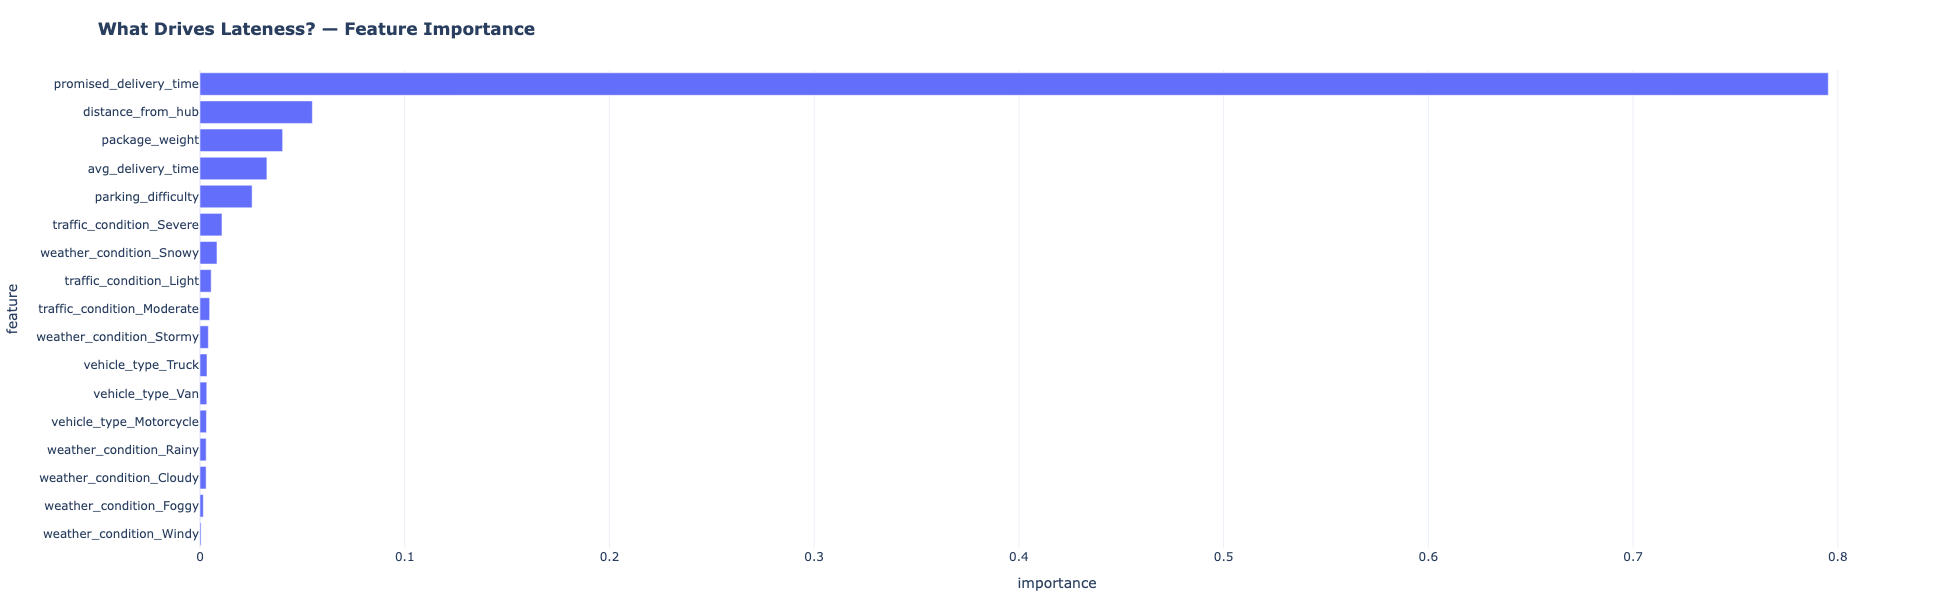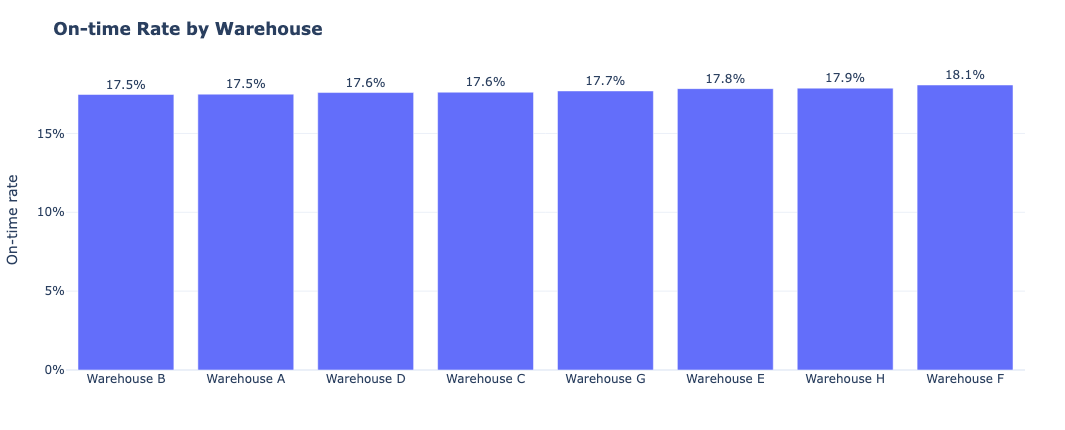“On-time Rate by Warehouse” — even across warehouses, rates cluster ~17–18%, showing systemic rather than location-driven issues.*

**Takeaway:** To move the needle, focus on **better ETA setting** and **routing**, not just vehicles or warehouses.

---

## 2) How do weather and traffic conditions affect delivery performance?

- **Snowy + Severe traffic** is the worst combination, pushing average delays to ~10 hours.  
- **Stormy/Rainy** also hurt; **Clear/Cloudy** are safest.  
- Traffic amplifies delays stepwise: *Light → Moderate → Heavy → Severe*.  

📊 *See plots: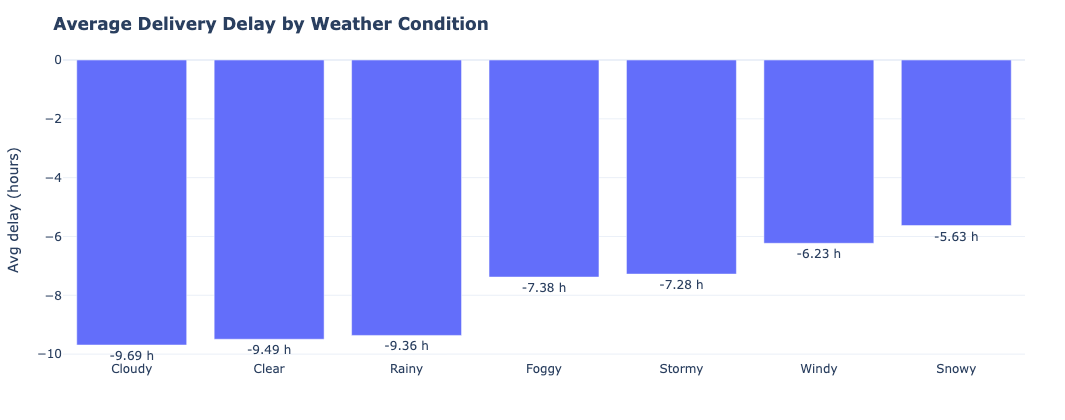 “Average Delay by Weather Condition” and “Average Delay by Traffic Condition.”*

**Takeaway:** proactively **add buffers and re-route** during snow/storm days with severe traffic. These events are rare but devastating.

---

## 3) Which delivery zones perform worst?

- **Slowest zones:** Zone 4, Zone 6, Zone 13, Zone 24, Zone 28 (avg delays −6h to −8.7h).  
- **Best zones:** Zone 20, Zone 15, Zone 10, Zone 14, Zone 16 (avg delays −10h to −12h).  

📊 *See plots: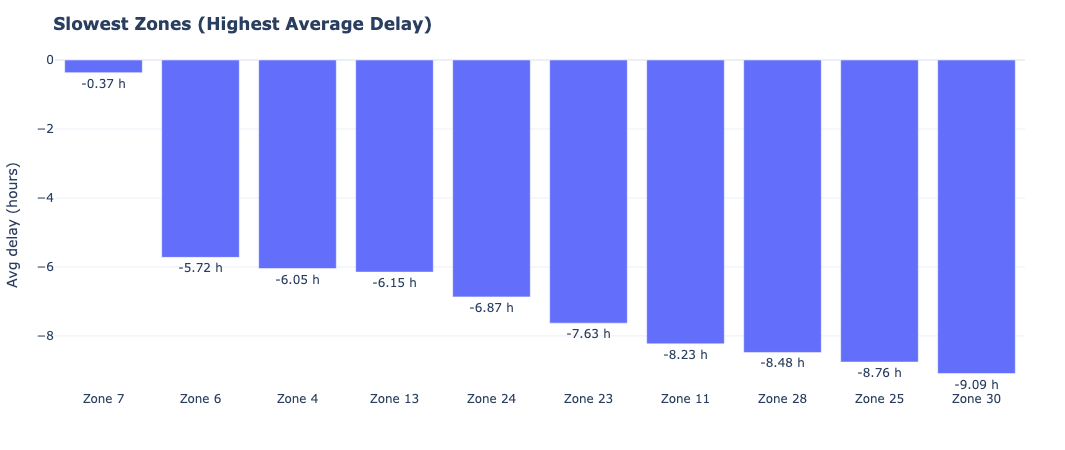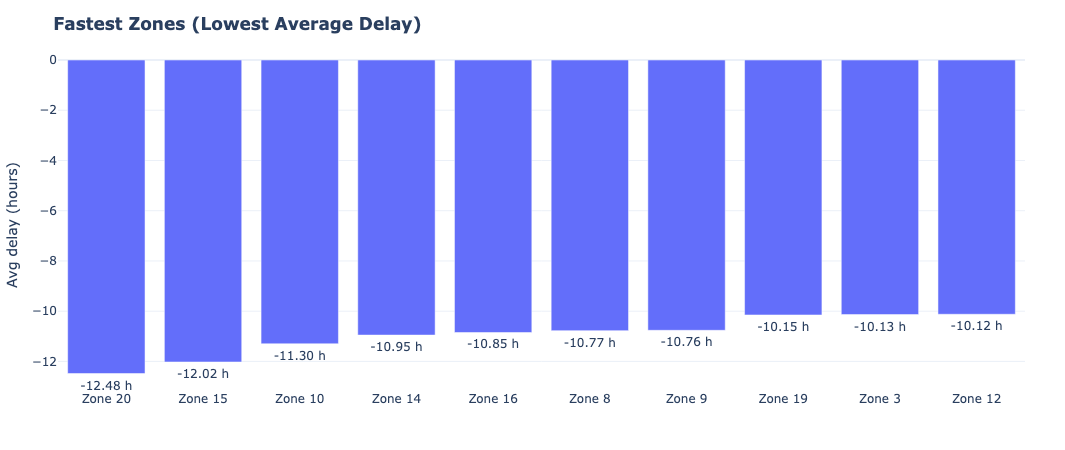 “Slowest Zones” and “Fastest Zones.”*

**Takeaway:** focus on **red-flag zones first** with micro-routing, parking solutions, and more agile vehicle mix. Use high-performing zones as benchmarks.

---

## Additional Insights

### A) Drivers matter
- Top driver on-time ≈ **35%** vs bottom drivers ≈ **14%**.  
📊 *See plots: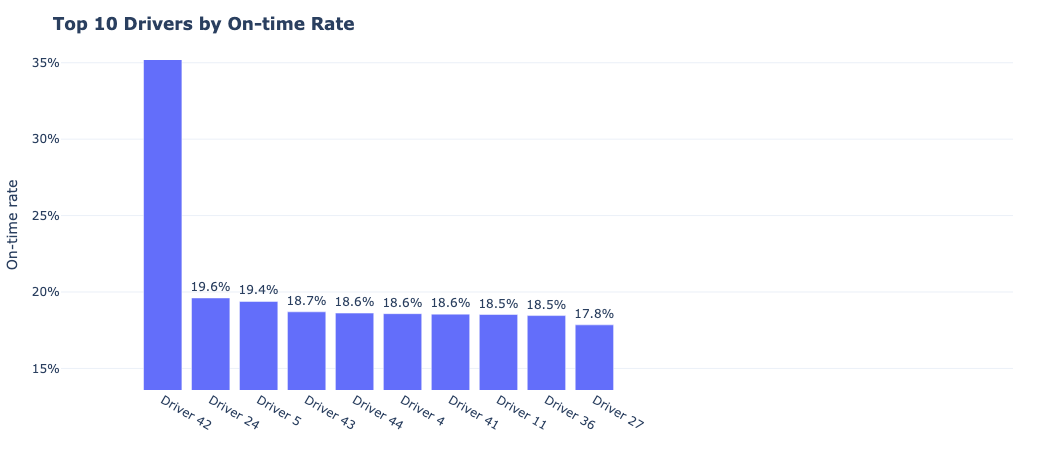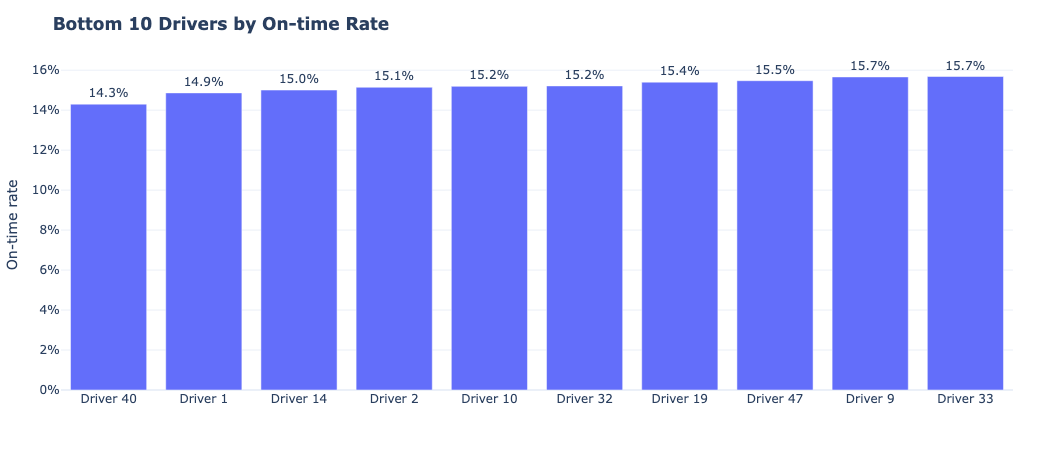 “Top 10 Drivers” vs “Bottom 10 Drivers.”*  
- Peer coaching and route-knowledge sharing can bring the median up.

### B) Customer satisfaction follows delay
- Ratings drop sharply as delays grow: **on-time deliveries get median rating 4**, vs **6–12h late → median 2–3**.  
📊 *See plot: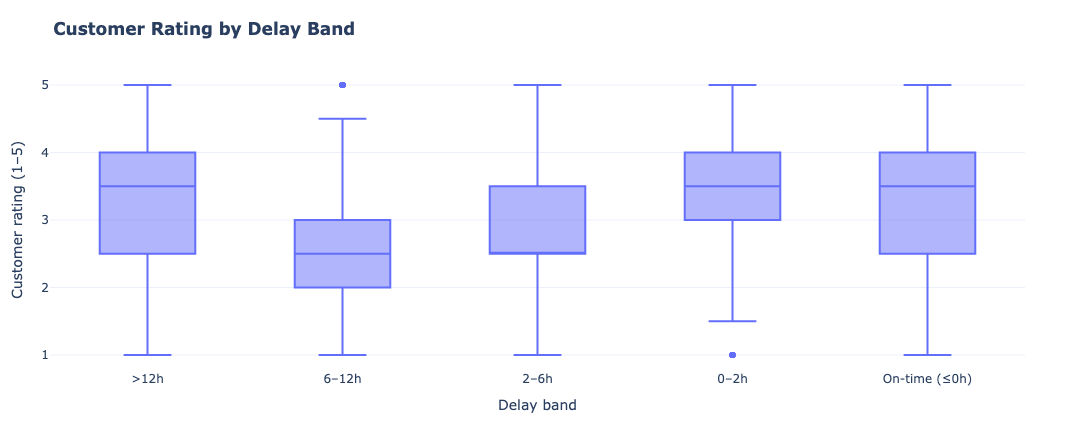 “Customer Rating by Delay Band.”*  
- Cutting medium delays (2–6h) can meaningfully improve satisfaction.

### C) Profitability isn’t tied to punctuality
- Scatter shows **no correlation** between delay and profitability.  
📊 *See plot: 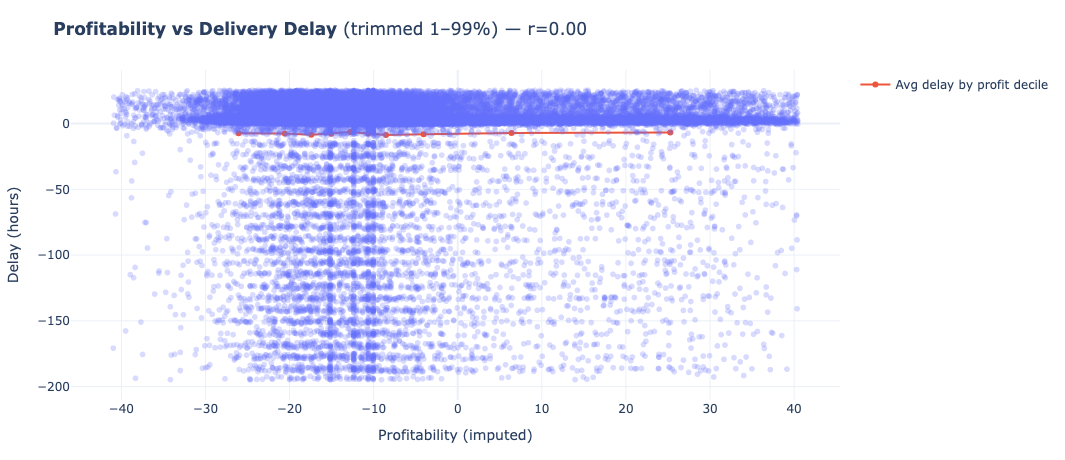“Profitability vs Delivery Delay.”*  
- Still, unit economics reveal congestion and vehicle costs drive losses.

---

# Personal Insights

- **Profitability ≠ Punctuality:** At the single-delivery level, profit shows almost no correlation with delay.  
  → Losses appear to come more from congestion and structural cost pressures than from punctuality itself.

- **Zone paradoxes:** Some zones deliver **fast but still receive poor ratings** (likely customer expectations or mix), while others are **slower yet maintain decent ratings** (possibly due to better communication or more forgiving customers).  
  → These mismatches deserve deeper investigation.
---

## Recommendations

1. **Recalibrate ETAs** using historical zone × traffic × weather data.  
2. **Zone playbooks**: prioritize Zones 4, 6, 13, 24, 28 with pilots.  
3. **Driver uplift**: coach the bottom decile, spread best practices.  
4. **Economics guardrails**: track cost/hour, profit/liter by corridor.  
5. **Customer strategy**: add minimum fees or batching for loss-making accounts; protect high-value clients.

---

## Executive Summary (30 seconds)

- **On-time ≈ 18%**, median delay **2.8h**, P90 **17.6h**.  
- **Levers:** ETA promises and routing matter most.  
- **Weather × Traffic:** snow/storm + severe traffic = worst case.  
- **Zones:** fix Zones 4/6/13/24/28; copy best practices from Zones 20/15/10/14/16.  
- **Drivers:** huge gap (35% vs 14%) — coaching is key.  
- **Finance:** profit unaffected by punctuality at single delivery level; costs driven by congestion and vehicle mix.

---


# Skills Demonstrated

### 1. Data Engineering
- Checked data quality with simple assertions (nulls, negatives, join consistency).
- Filled missing values using sensible group-wise medians (by package type / vehicle type) and global fallback.
- Created new features like `delay`, delay buckets, profitability (raw + imputed), and zone-level KPIs.
- Combined the deliveries, drivers, warehouses, and zones tables with key-based joins.

### 2. Analytical Thinking
- Focused on variables that actually drive performance: promised delivery time, distance, weight, parking difficulty, and weather/traffic.
- Drew insights such as ETA commitments being the main driver, the compounding effect of snow + severe traffic, and large performance gaps across zones and drivers.
- Noticed anomalies like profit having almost no link with punctuality, and zones where speed and ratings don’t line up.

### 3. Technical Implementation
- Kept the code structured with small helper functions and clear separation of exploration vs. modeling.
- Used RandomForest feature importance, groupby aggregations, pivot tables, and Pareto analysis to dig into patterns.
- Built visualizations (heatmaps, bar charts, scatterplots, boxplots) to make the findings easy to explain.
